In [1]:
import GAN.models as models
import GAN.cms_datasets as cms
import GAN.plotting as plotting
import GAN.preprocessing as preprocessing
import GAN.base as base

Using TensorFlow backend.


In [2]:
import GAN.utils as utils

reload(utils)

class Parameters(utils.Parameters):
    
    load_datasets=utils.param(["moriond_v9","abs(ScEta) < 1.5"])

    c_names = utils.param(['Pt','ScEta','Phi','rho'])
    x_names = utils.param(['R9','SigmaIeIe','S4','EtaWidth','PhiWidth','CovarianceIetaIphi',
               'CovarianceIphiIphi', ])
    
    feat_transform = utils.param('minmax')
    
    g_opts=utils.param(dict(name="G_64x5",kernel_sizes=[64]*5))
    d_opts=utils.param(dict(name="D_256x5",kernel_sizes=[256]*5))
    dm_opts=utils.param(dict(optimizer="RMSprop",opt_kwargs=dict(lr=0.0002, decay=6e-6)))
    am_opts=utils.param(dict(optimizer="RMSprop",opt_kwargs=dict(lr=0.0002, decay=6e-6)))
    
    epochs=utils.param(10)
    batch_size=utils.param(4096)
    plot_every=utils.param(5)
    
    frac_data=utils.param(1000)
    
class MyApp(utils.MyApp):
    classes = utils.List([Parameters])

notebook_parameters = Parameters(MyApp()).get_params()

globals().update(notebook_parameters)
notebook_parameters


{'AM_OPTS': {'opt_kwargs': {'decay': 6e-06, 'lr': 0.0002},
  'optimizer': 'RMSprop'},
 'BATCH_SIZE': 4096,
 'C_NAMES': ['Pt', 'ScEta', 'Phi', 'rho'],
 'DM_OPTS': {'opt_kwargs': {'decay': 6e-06, 'lr': 0.0002},
  'optimizer': 'RMSprop'},
 'D_OPTS': {'kernel_sizes': [256, 256, 256, 256, 256], 'name': 'D_256x5'},
 'EPOCHS': 10,
 'FEAT_TRANSFORM': 'minmax',
 'FRAC_DATA': 1000,
 'G_OPTS': {'kernel_sizes': [64, 64, 64, 64, 64], 'name': 'G_64x5'},
 'LOAD_DATASETS': ['moriond_v9', 'abs(ScEta) < 1.5'],
 'PLOT_EVERY': 5,
 'X_NAMES': ['R9',
  'SigmaIeIe',
  'S4',
  'EtaWidth',
  'PhiWidth',
  'CovarianceIetaIphi',
  'CovarianceIphiIphi']}

In [3]:
reload(cms)

data,mc = cms.load_zee(*LOAD_DATASETS)


In [4]:
data.columns

Index(['index', 'run', 'rho', 'nvtx', 'mass', 'weight', 'SigMoM', 'Pt',
       'ScEta', 'Phi', 'R9', 'S4', 'SigmaIeIe', 'EtaWidth', 'PhiWidth',
       'CovarianceIphiIphi', 'SigmaRR', 'ScEnergy', 'CovarianceIetaIphi',
       'PhoIso03', 'ChIso03', 'ChIso03worst', 'ScPreshowerEnergy', 'PhoIDMVA',
       'SigEOverE', 'run_quantile'],
      dtype='object')

In [5]:
mc.columns

Index(['index', 'run', 'rho', 'nvtx', 'mass', 'weight', 'SigMoM', 'Pt',
       'ScEta', 'Phi', 'R9', 'S4', 'SigmaIeIe', 'EtaWidth', 'PhiWidth',
       'CovarianceIphiIphi', 'SigmaRR', 'ScEnergy', 'CovarianceIetaIphi',
       'PhoIso03', 'ChIso03', 'ChIso03worst', 'ScPreshowerEnergy', 'PhoIDMVA',
       'SigEOverE'],
      dtype='object')

In [6]:
c_names = C_NAMES
x_names = X_NAMES

data_c = data[c_names]
data_x = data[x_names]

mc_c = mc[c_names]
mc_x = mc[x_names]


In [7]:
data_x.columns, data_x.shape, data_c.columns, data_c.shape

(Index(['R9', 'SigmaIeIe', 'S4', 'EtaWidth', 'PhiWidth', 'CovarianceIetaIphi',
        'CovarianceIphiIphi'],
       dtype='object'),
 (17520217, 7),
 Index(['Pt', 'ScEta', 'Phi', 'rho'], dtype='object'),
 (17520217, 4))

In [8]:
data_x.columns, data_c.columns

(Index(['R9', 'SigmaIeIe', 'S4', 'EtaWidth', 'PhiWidth', 'CovarianceIetaIphi',
        'CovarianceIphiIphi'],
       dtype='object'), Index(['Pt', 'ScEta', 'Phi', 'rho'], dtype='object'))

In [9]:
mc_x.columns, mc_c.columns

(Index(['R9', 'SigmaIeIe', 'S4', 'EtaWidth', 'PhiWidth', 'CovarianceIetaIphi',
        'CovarianceIphiIphi'],
       dtype='object'), Index(['Pt', 'ScEta', 'Phi', 'rho'], dtype='object'))

In [10]:
reload(models)

xz_shape = (1,len(x_names))
c_shape = (1,len(c_names))
gan = models.MyFFGAN( xz_shape, xz_shape, c_shape=c_shape,
                     g_opts=G_OPTS,
                     d_opts=D_OPTS,
                     dm_opts=DM_OPTS,
                     am_opts=AM_OPTS,
                    )

In [11]:
gan.get_generator()

(1, 7)


In [12]:
gan.get_discriminator()

In [13]:
gan.adversarial_compile()

In [14]:
gan.get_generator().summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
G_64x5_c_input (InputLayer)      (None, 1, 4)          0                                            
____________________________________________________________________________________________________
G_64x5_input (InputLayer)        (None, 1, 7)          0                                            
____________________________________________________________________________________________________
G_64x5_all_inputs (Concatenate)  (None, 1, 11)         0           G_64x5_c_input[0][0]             
                                                                   G_64x5_input[0][0]               
____________________________________________________________________________________________________
G_64x5_up1_dense (Dense)         (None, 1, 64)         768         G_64x5_all_inputs[0][0] 

In [15]:
gan.get_discriminator().summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
D_256x5_c_input (InputLayer)     (None, 1, 4)          0                                            
____________________________________________________________________________________________________
D_256x5_input (InputLayer)       (None, 1, 7)          0                                            
____________________________________________________________________________________________________
D_256x5_all_inputs (Concatenate) (None, 1, 11)         0           D_256x5_c_input[0][0]            
                                                                   D_256x5_input[0][0]              
____________________________________________________________________________________________________
D_256x5_down1_dense (Dense)      (None, 1, 256)        3072        D_256x5_all_inputs[0][0]

In [16]:
gan.am.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
G_64x5_c_input (InputLayer)      (None, 1, 4)          0                                            
____________________________________________________________________________________________________
G_64x5_input (InputLayer)        (None, 1, 7)          0                                            
____________________________________________________________________________________________________
G_64x5_all_inputs (Concatenate)  (None, 1, 11)         0           G_64x5_c_input[0][0]             
                                                                   G_64x5_input[0][0]               
____________________________________________________________________________________________________
G_64x5_up1_dense (Dense)         (None, 1, 64)         768         G_64x5_all_inputs[0][0] 

In [17]:
gan.dm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
D_256x5_c_input (InputLayer)     (None, 1, 4)          0                                            
____________________________________________________________________________________________________
D_256x5_input (InputLayer)       (None, 1, 7)          0                                            
____________________________________________________________________________________________________
D_256x5_all_inputs (Concatenate) (None, 1, 11)         0           D_256x5_c_input[0][0]            
                                                                   D_256x5_input[0][0]              
____________________________________________________________________________________________________
D_256x5_down1_dense (Dense)      (None, 1, 256)        3072        D_256x5_all_inputs[0][0]

In [18]:
gan.gan.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
G_64x5_c_input (InputLayer)      (None, 1, 4)          0                                            
____________________________________________________________________________________________________
G_64x5_input (InputLayer)        (None, 1, 7)          0                                            
____________________________________________________________________________________________________
G_64x5_all_inputs (Concatenate)  (None, 1, 11)         0           G_64x5_c_input[0][0]             
                                                                   G_64x5_input[0][0]               
____________________________________________________________________________________________________
D_256x5_c_input (InputLayer)     (None, 1, 4)          0                                   

In [19]:
gan.gan.outputs, gan.gan.inputs

([<tf.Tensor 'model_2/D_256x5_output/Sigmoid:0' shape=(?, 1) dtype=float32>,
  <tf.Tensor 'D_256x5_output/Sigmoid:0' shape=(?, 1) dtype=float32>],
 [<tf.Tensor 'G_64x5_c_input:0' shape=(?, 1, 4) dtype=float32>,
  <tf.Tensor 'G_64x5_input:0' shape=(?, 1, 7) dtype=float32>,
  <tf.Tensor 'D_256x5_c_input:0' shape=(?, 1, 4) dtype=float32>,
  <tf.Tensor 'D_256x5_input:0' shape=(?, 1, 7) dtype=float32>])

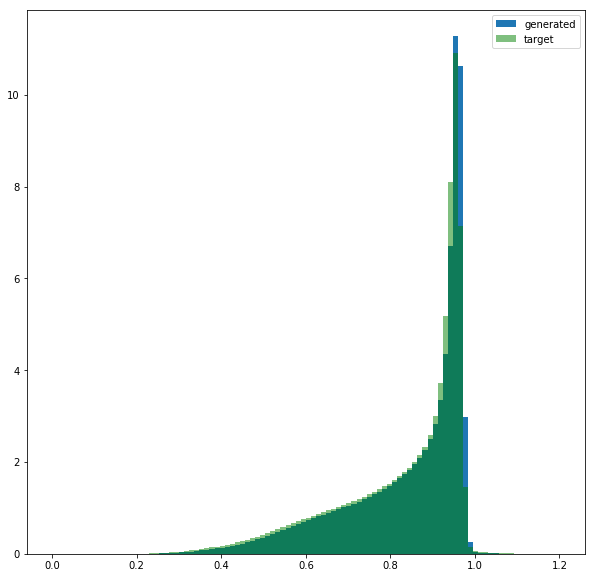

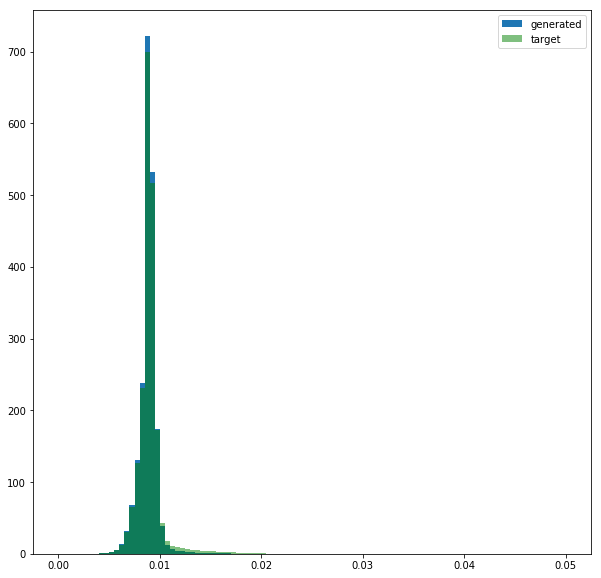

In [20]:
plotting.plot_hists(data_x.values[:,0],mc_x.values[:,0],bins=100,range=[0,1.2])
plt.show()
plotting.plot_hists(data_x.values[:,1],mc_x.values[:,1],bins=100,range=[0,5e-2])

In [21]:
reload(preprocessing)

data_x,data_c,mc_x,mc_c,scaler_x,scaler_c = preprocessing.transform(data_x,data_c,mc_x,mc_c,FEAT_TRANSFORM)


In [22]:
data_x.shape,mc_x.shape

((17520217, 1, 7), (9616192, 1, 7))

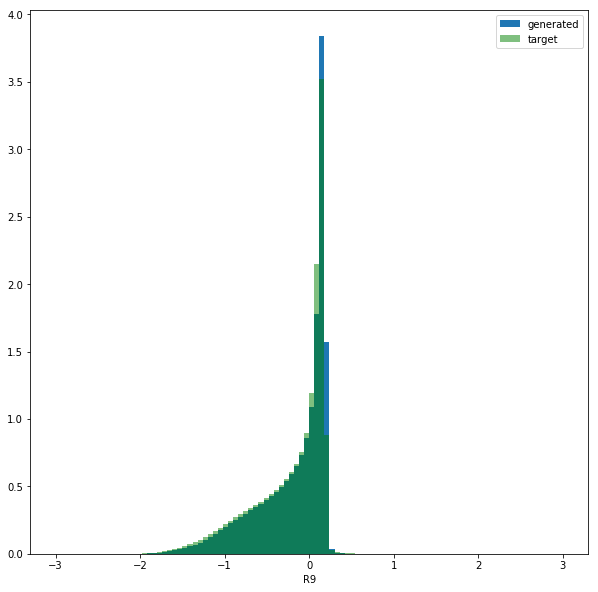

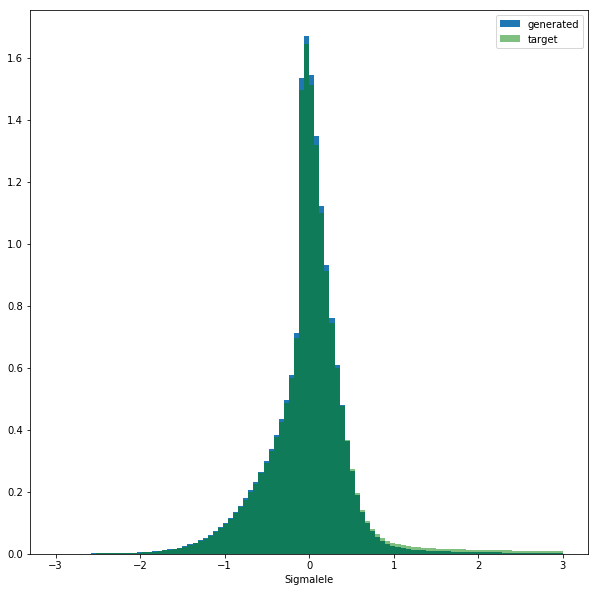

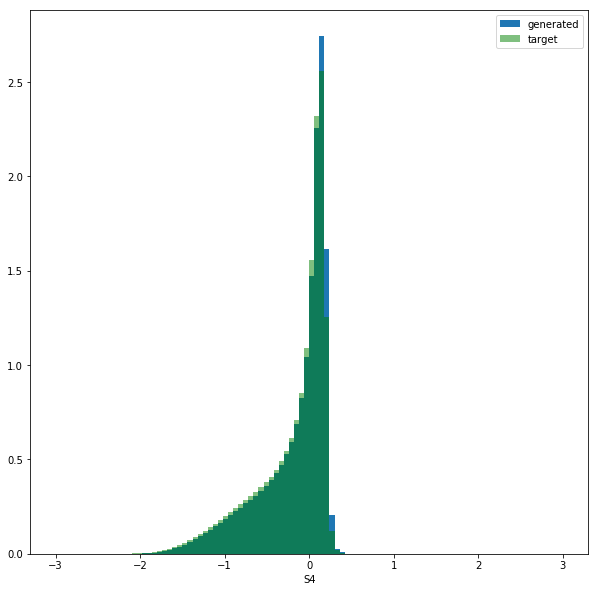

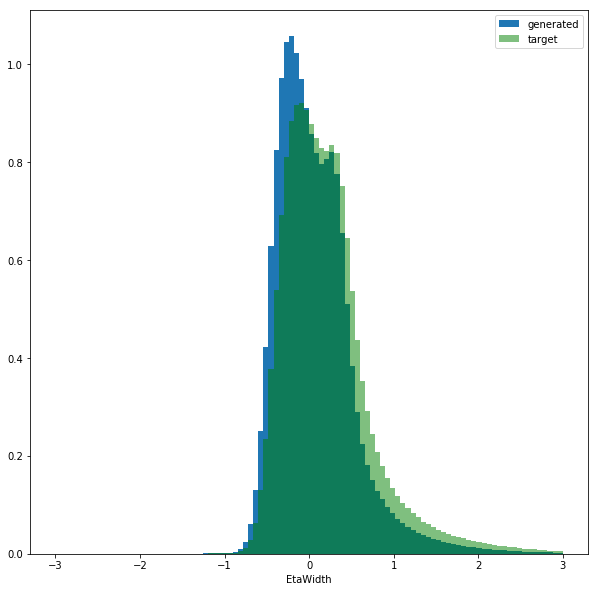

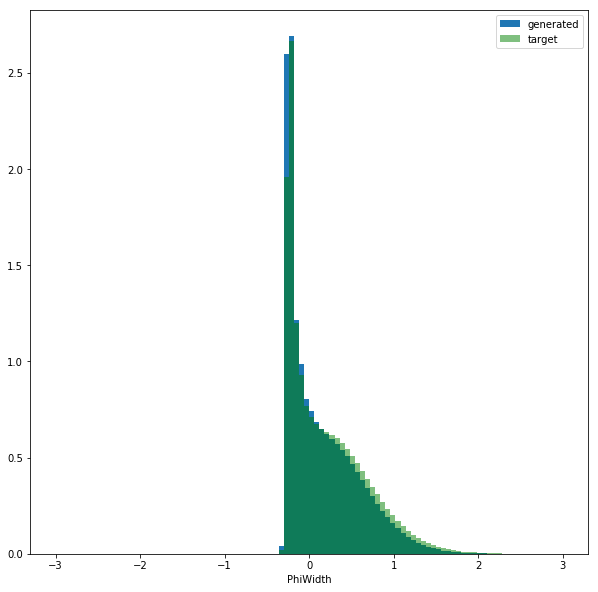

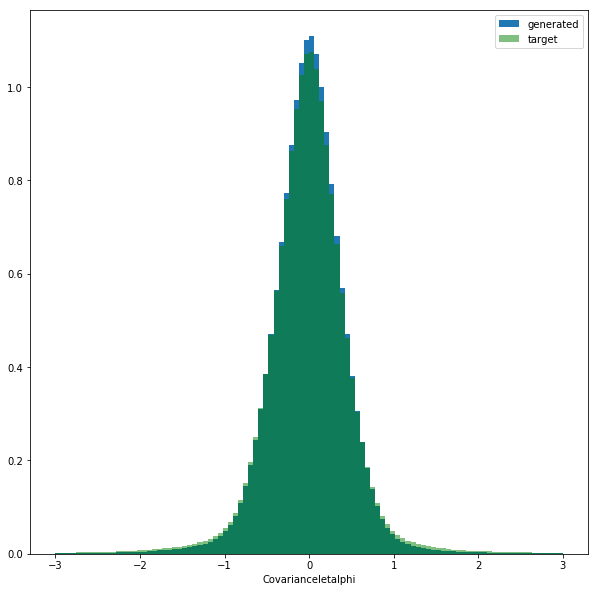

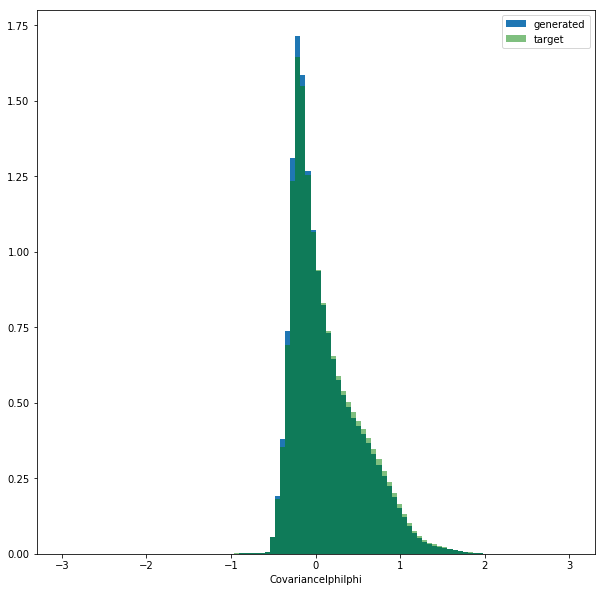

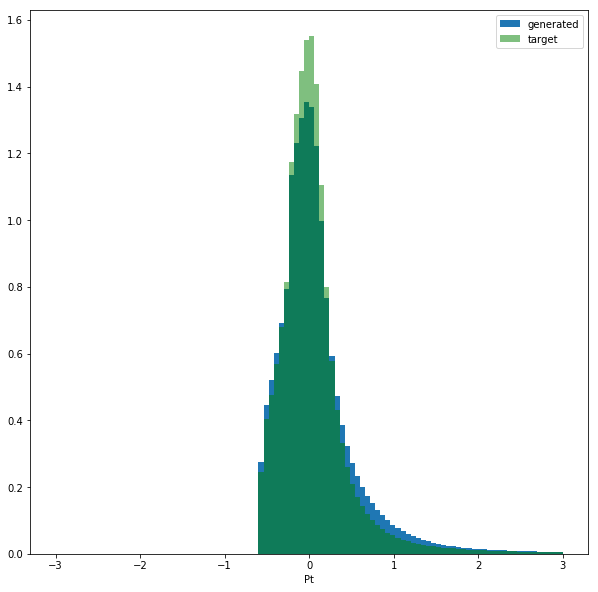

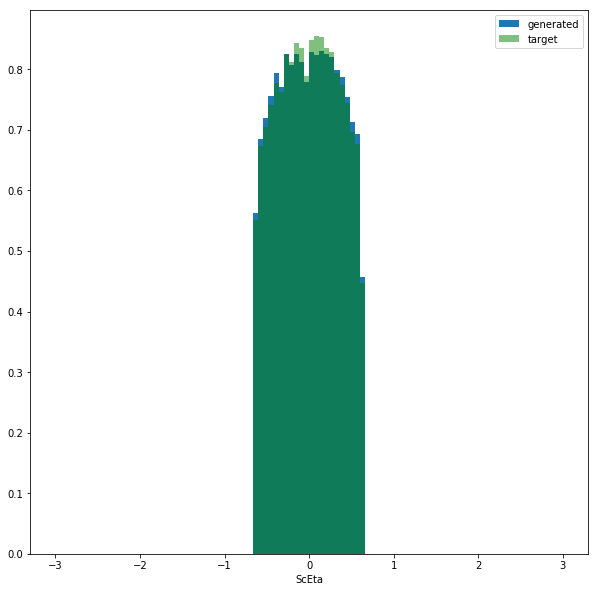

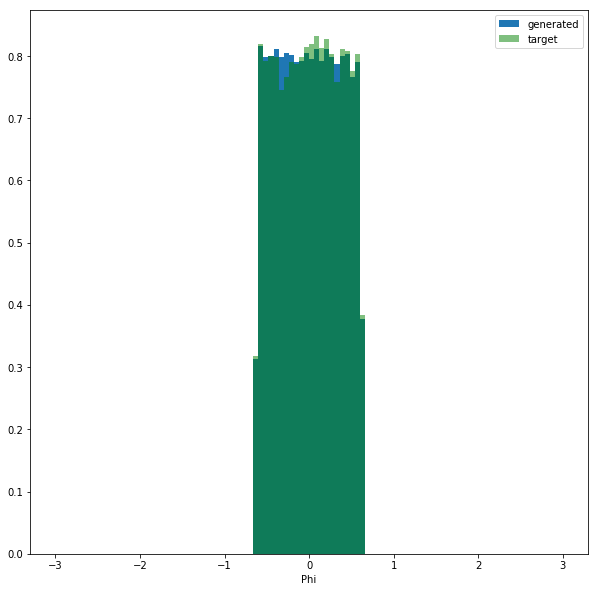

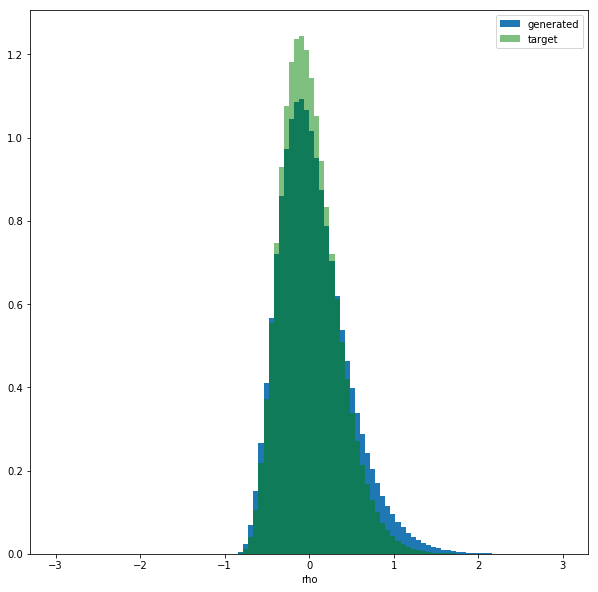

In [23]:
for ix in range(len(x_names)):
    plotting.plot_hists(data_x[:,0,ix],mc_x[:,0,ix],bins=100,range=[-3,3])
    plt.xlabel(x_names[ix])
    plt.show()

for ic in range(len(c_names)):
    plotting.plot_hists(data_c[:,0,ic],mc_c[:,0,ic],bins=100,range=[-3,3])
    plt.xlabel(c_names[ic])
    plt.show()


In [24]:
nmax = min(data_x.shape[0]//FRAC_DATA,mc_x.shape[0])

data_x_train,data_x_test,data_c_train,data_c_test = cms.train_test_split(data_x[:nmax],data_c[:nmax])
mc_x_train,mc_x_test,mc_c_train,mc_c_test = cms.train_test_split(mc_x[:nmax],mc_c[:nmax])

In [25]:
print(nmax)

17520


/users/musella/jupyter/GAN/base.py:122: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  callbacks = [plotter]


Epoch 1/10
12288/13140 [===========================>..] - ETA: 0s - loss: 2.7737 - generator_loss: 1.3936 - generator_model_2_loss: 0.6948 - generator_D_256x5_output_loss: 0.6988 - discriminator_loss: 1.3801 - discriminator_model_2_loss: 0.6919 - discriminator_D_256x5_output_loss: 0.6882

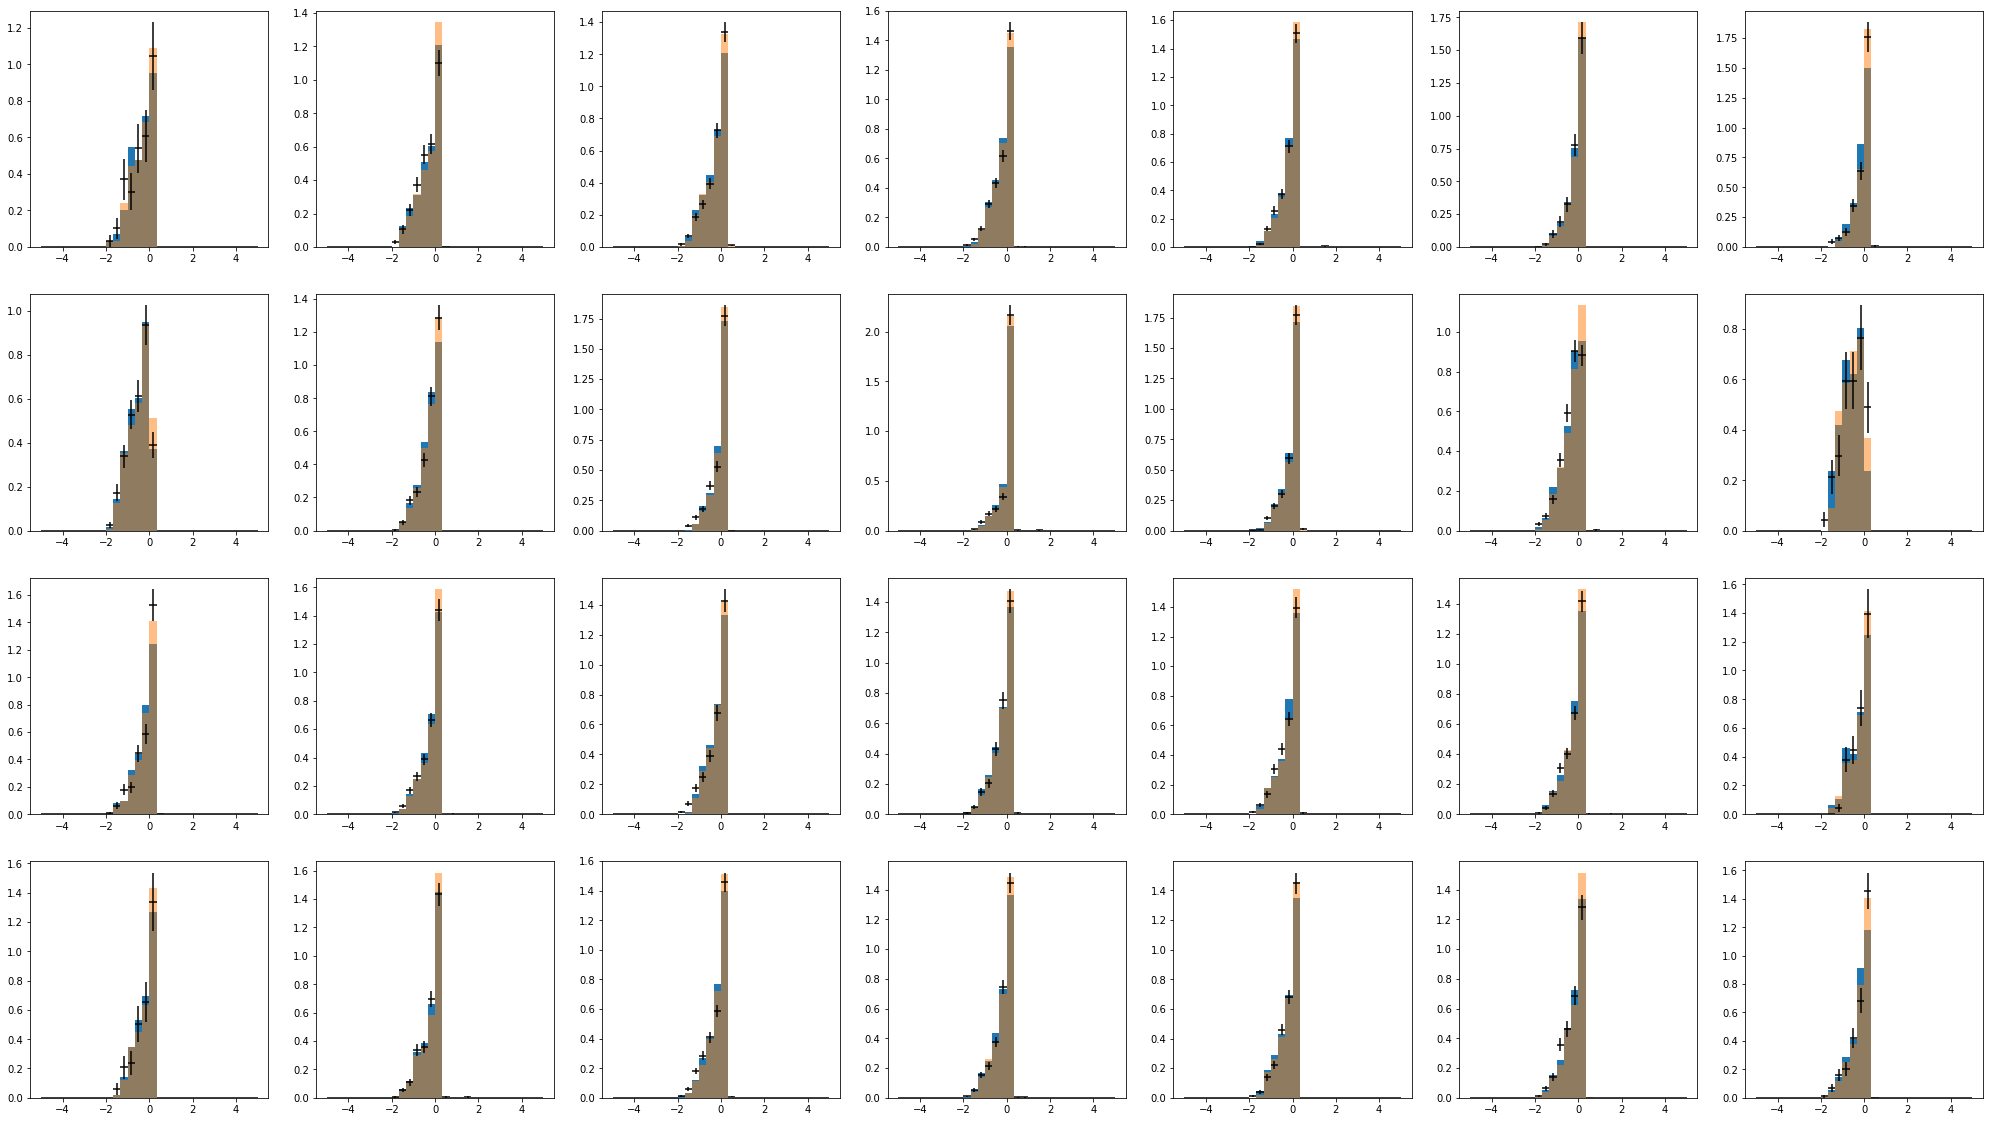

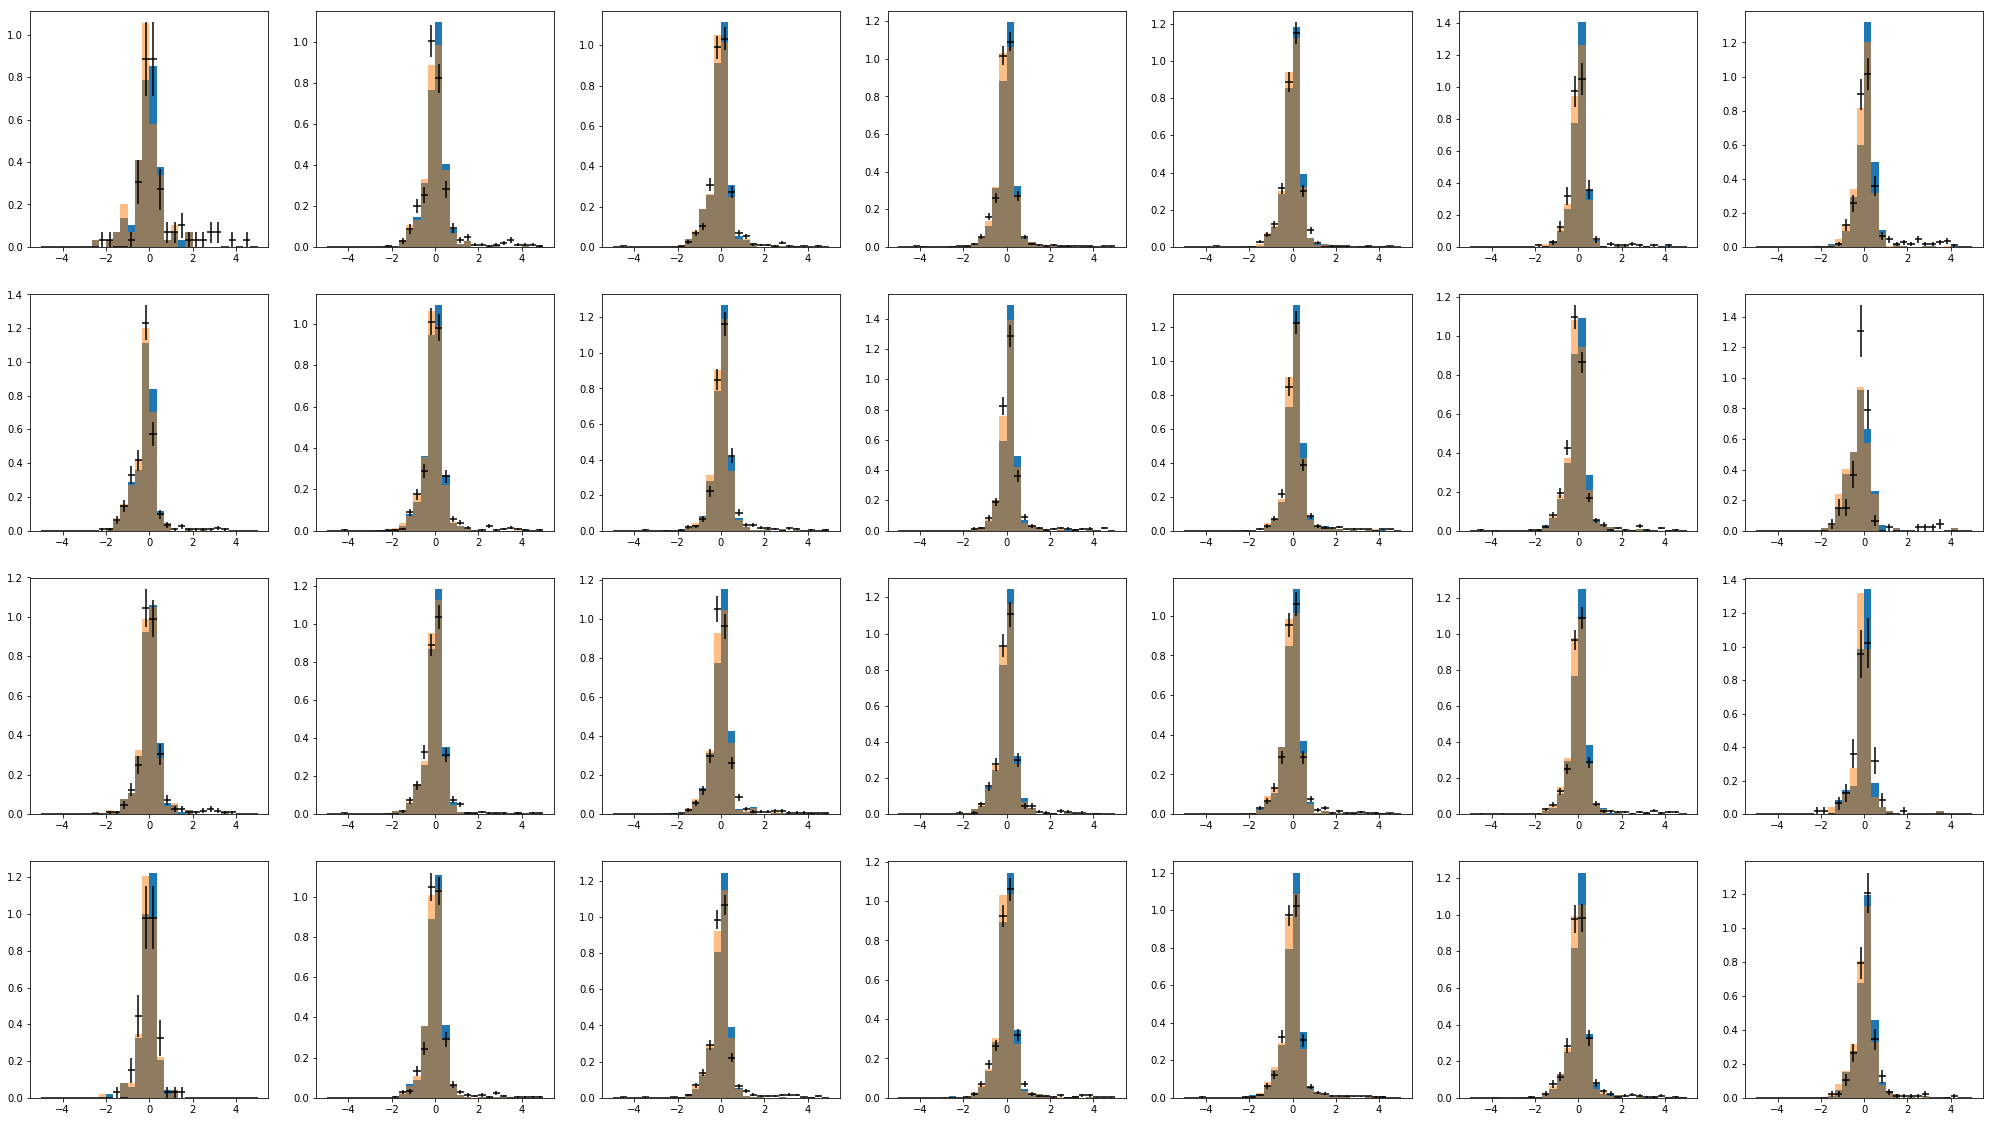

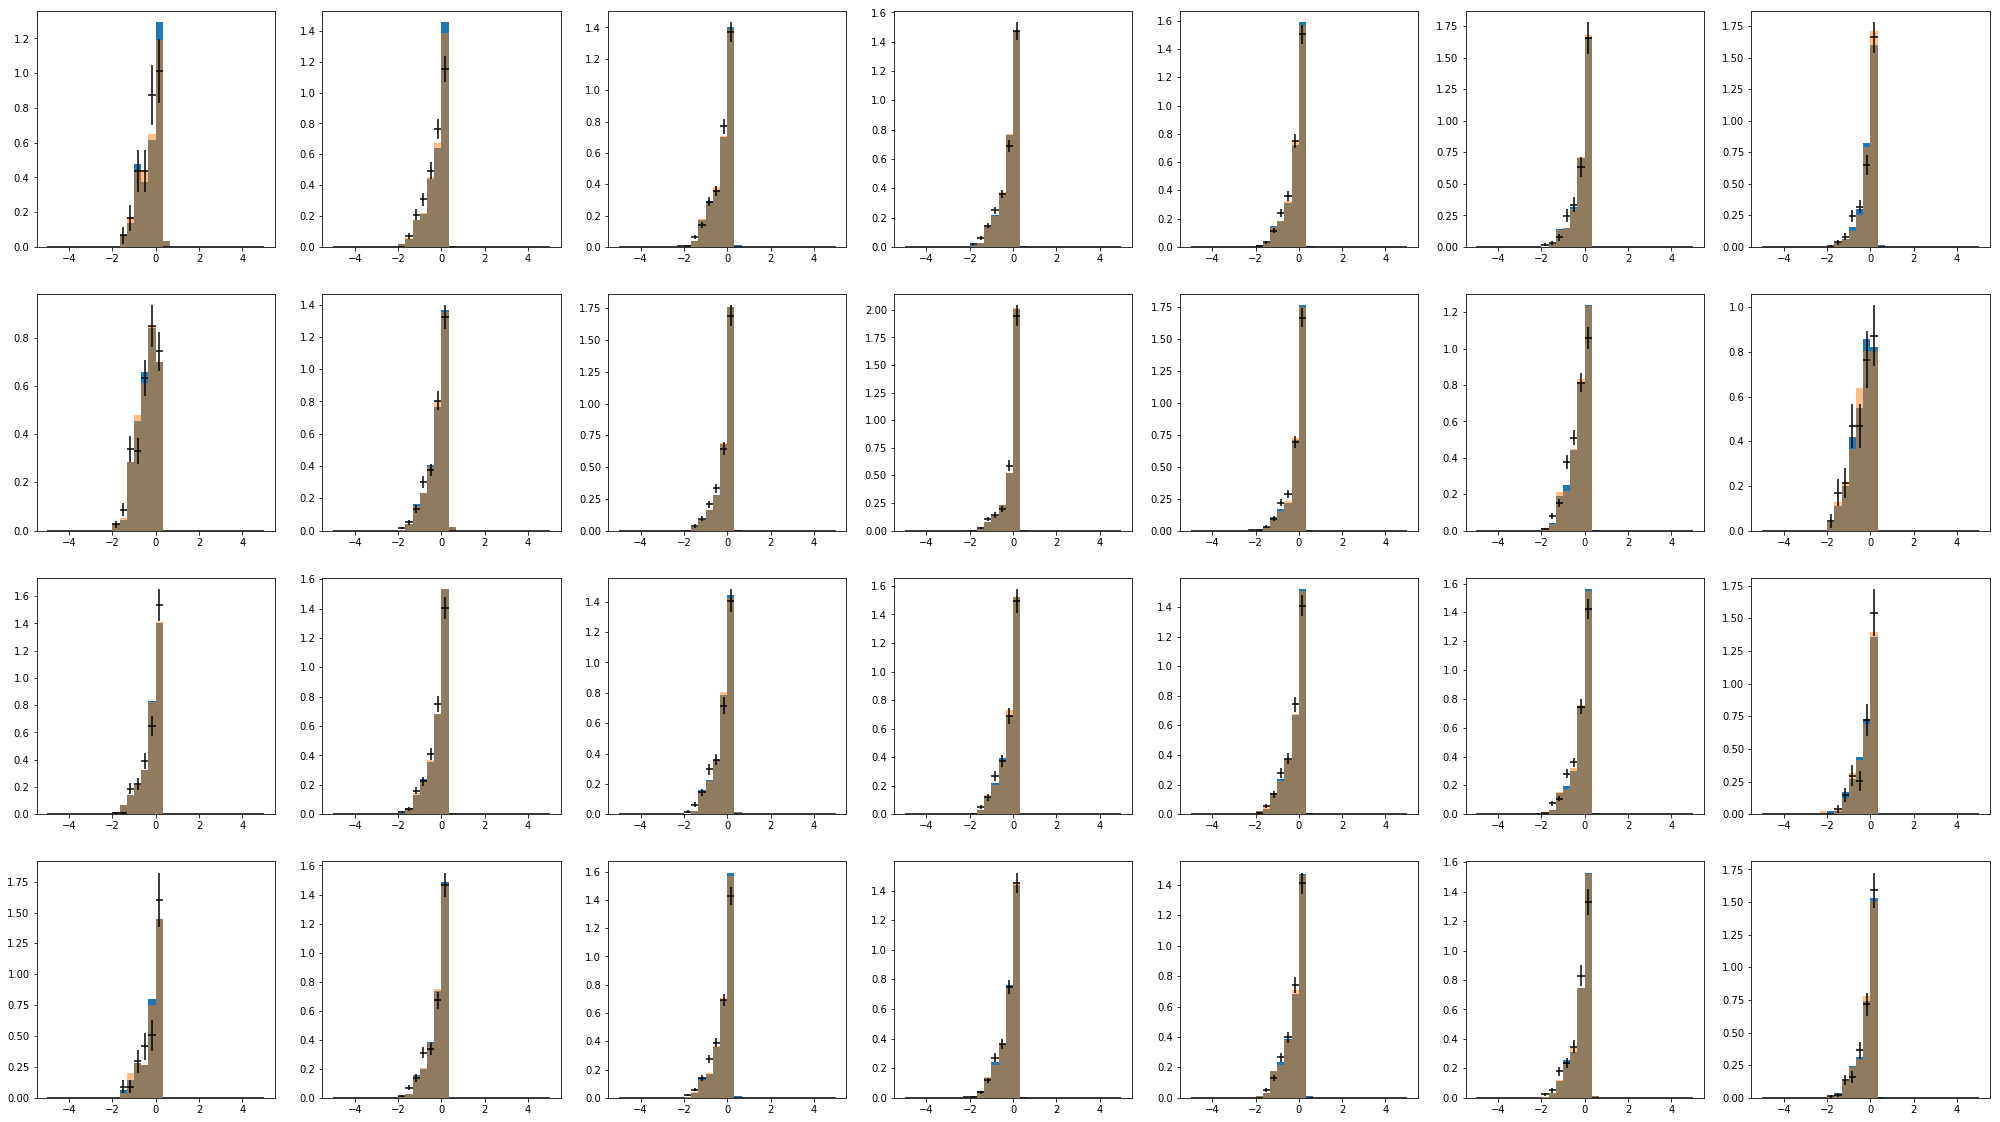

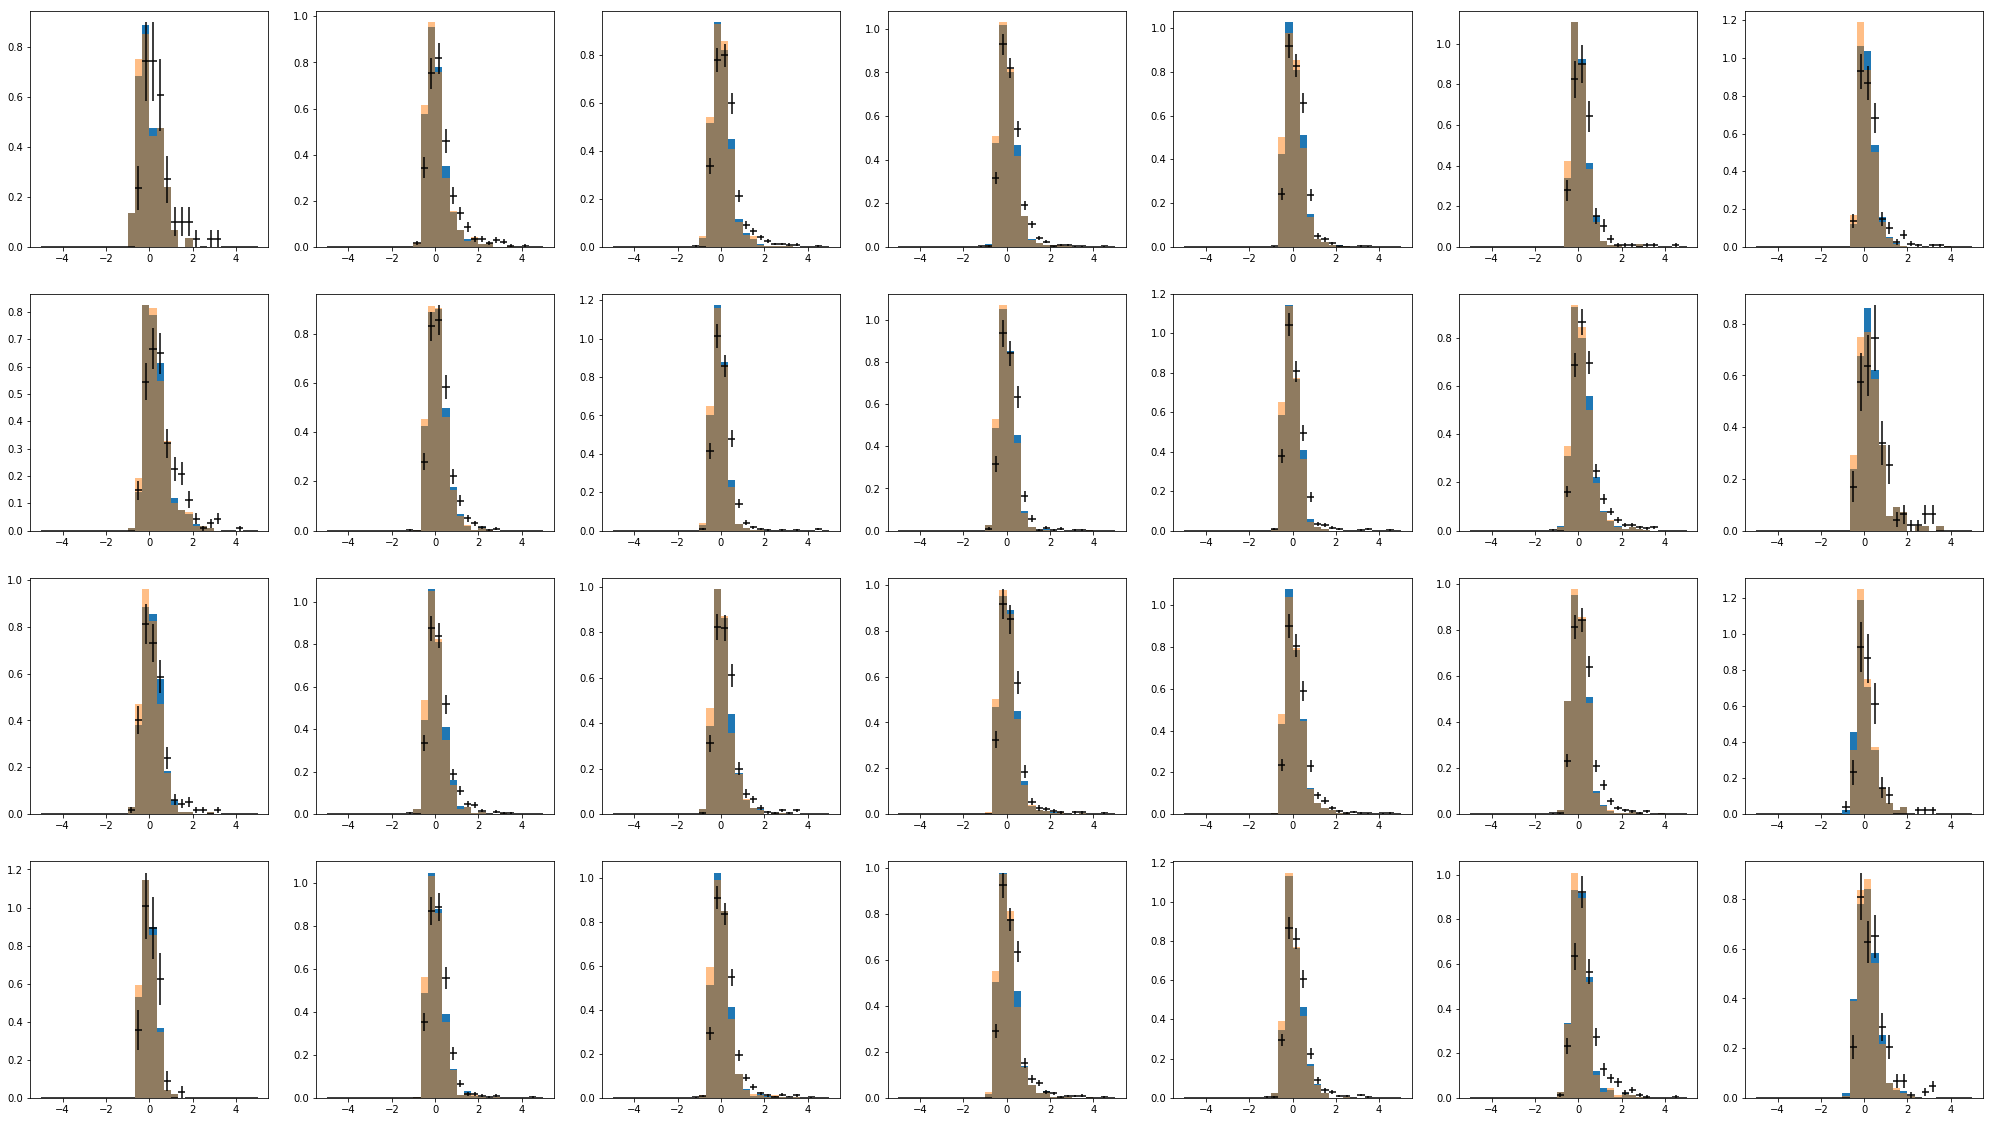

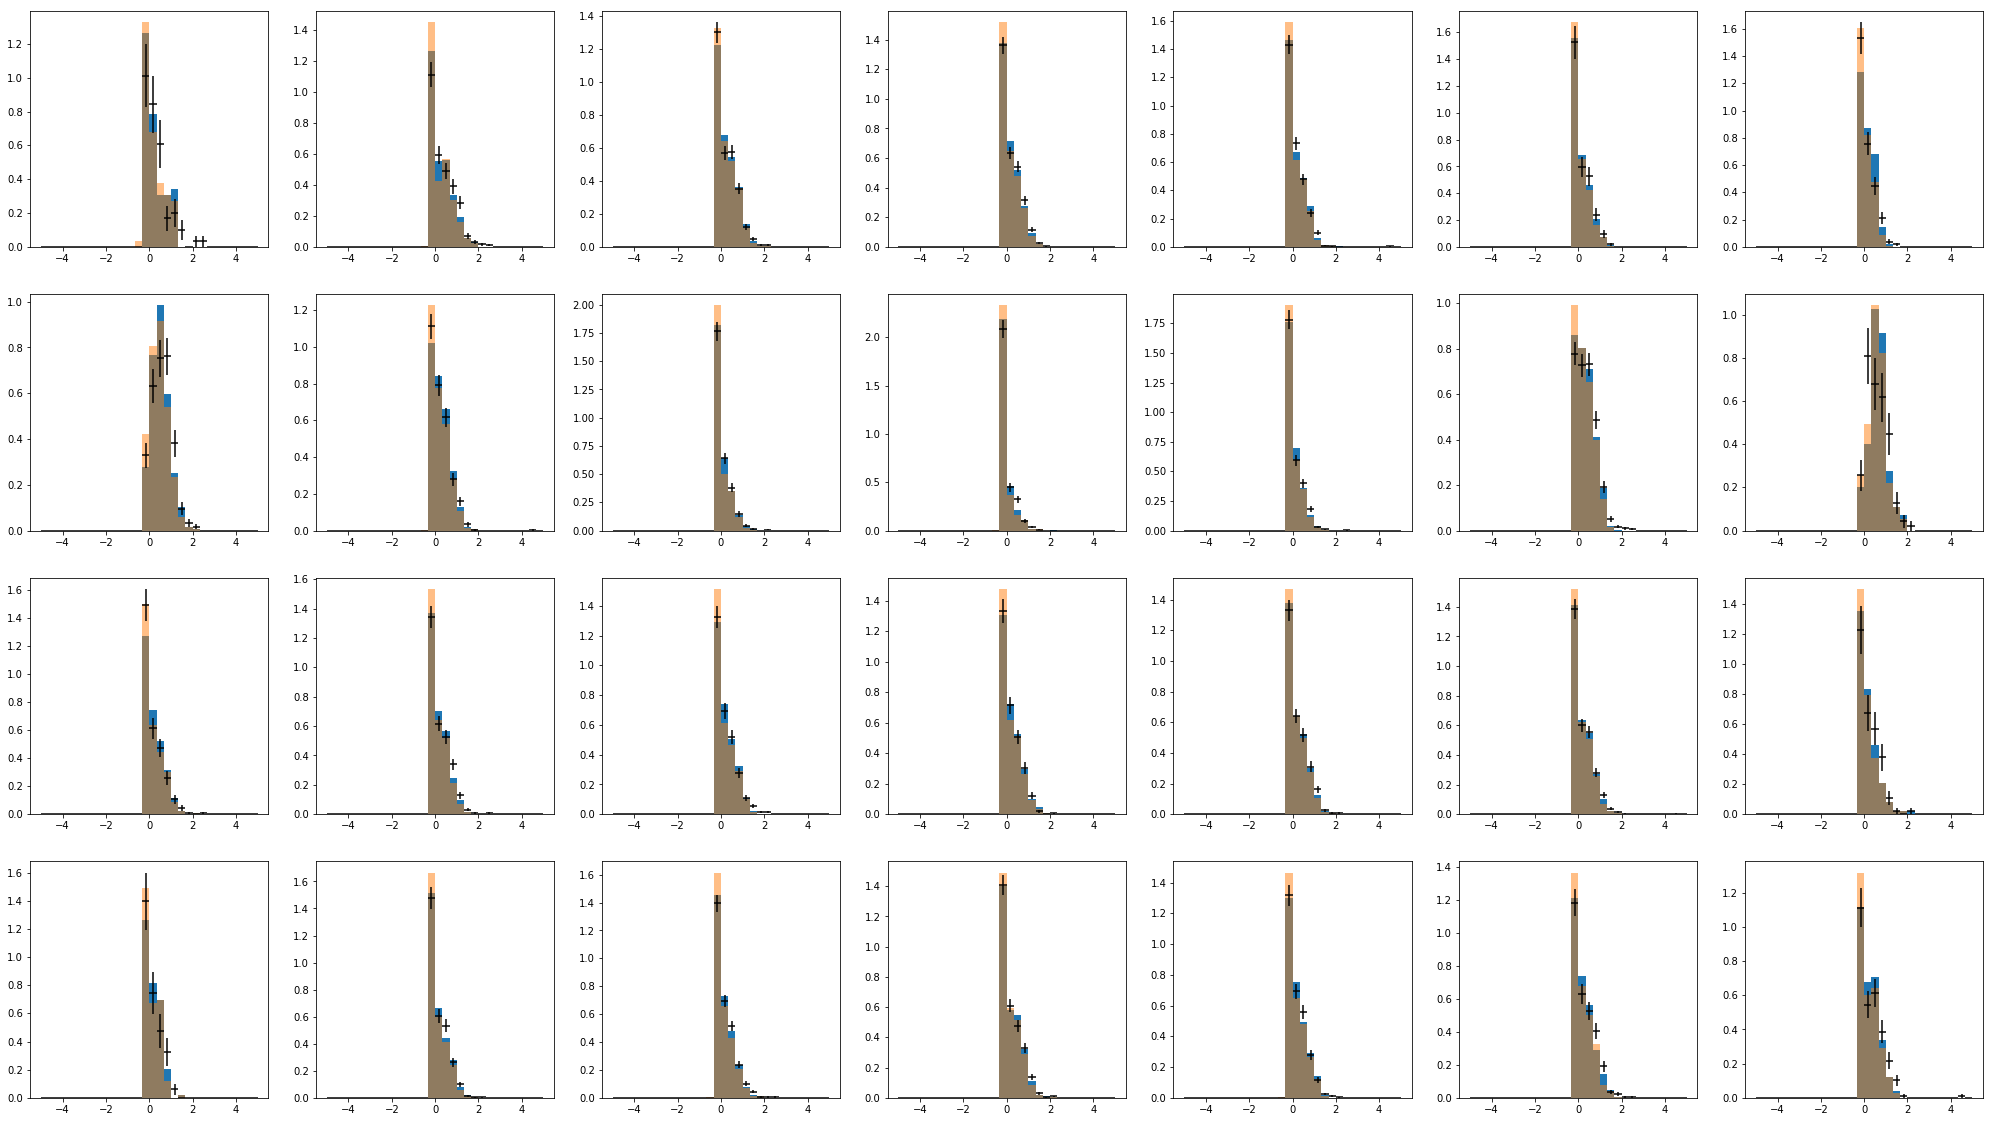

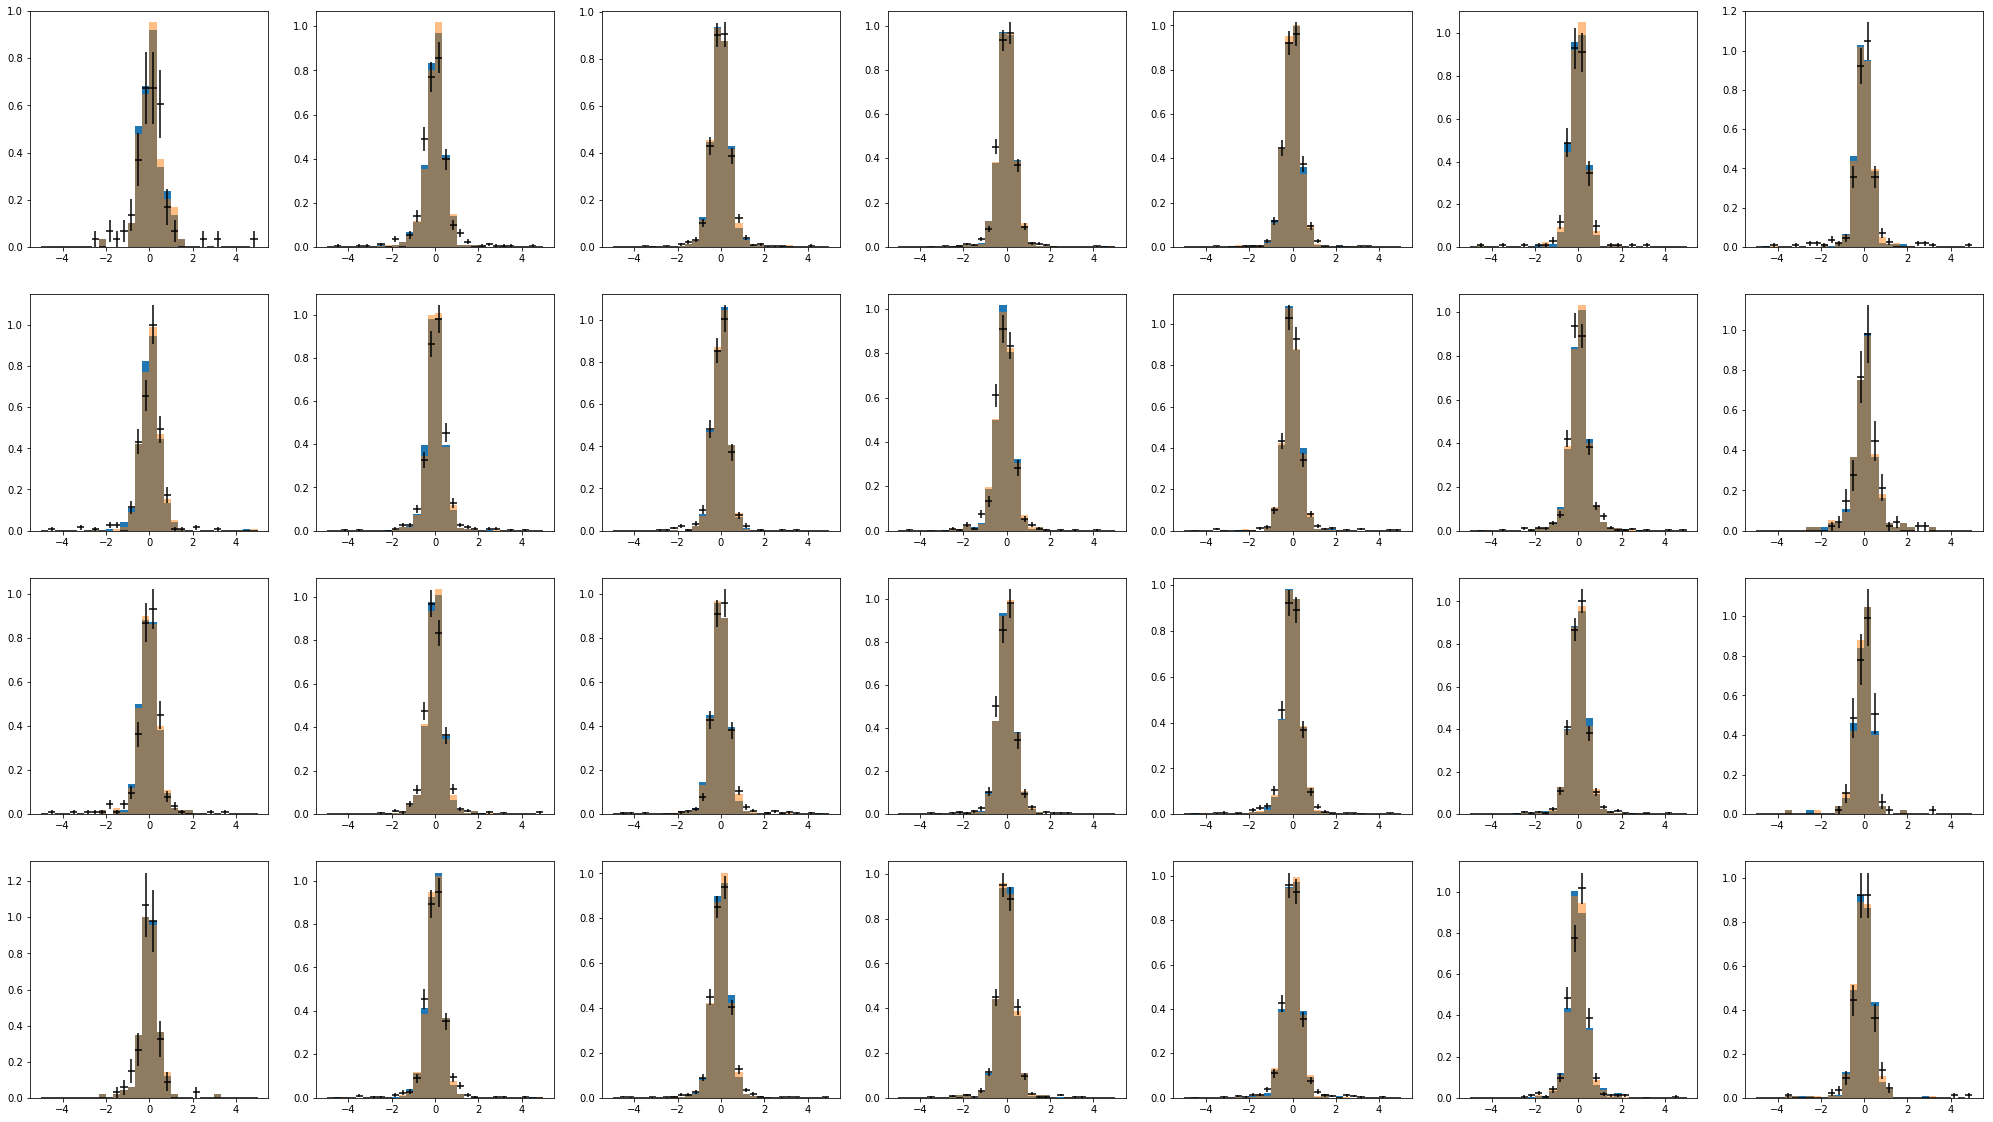

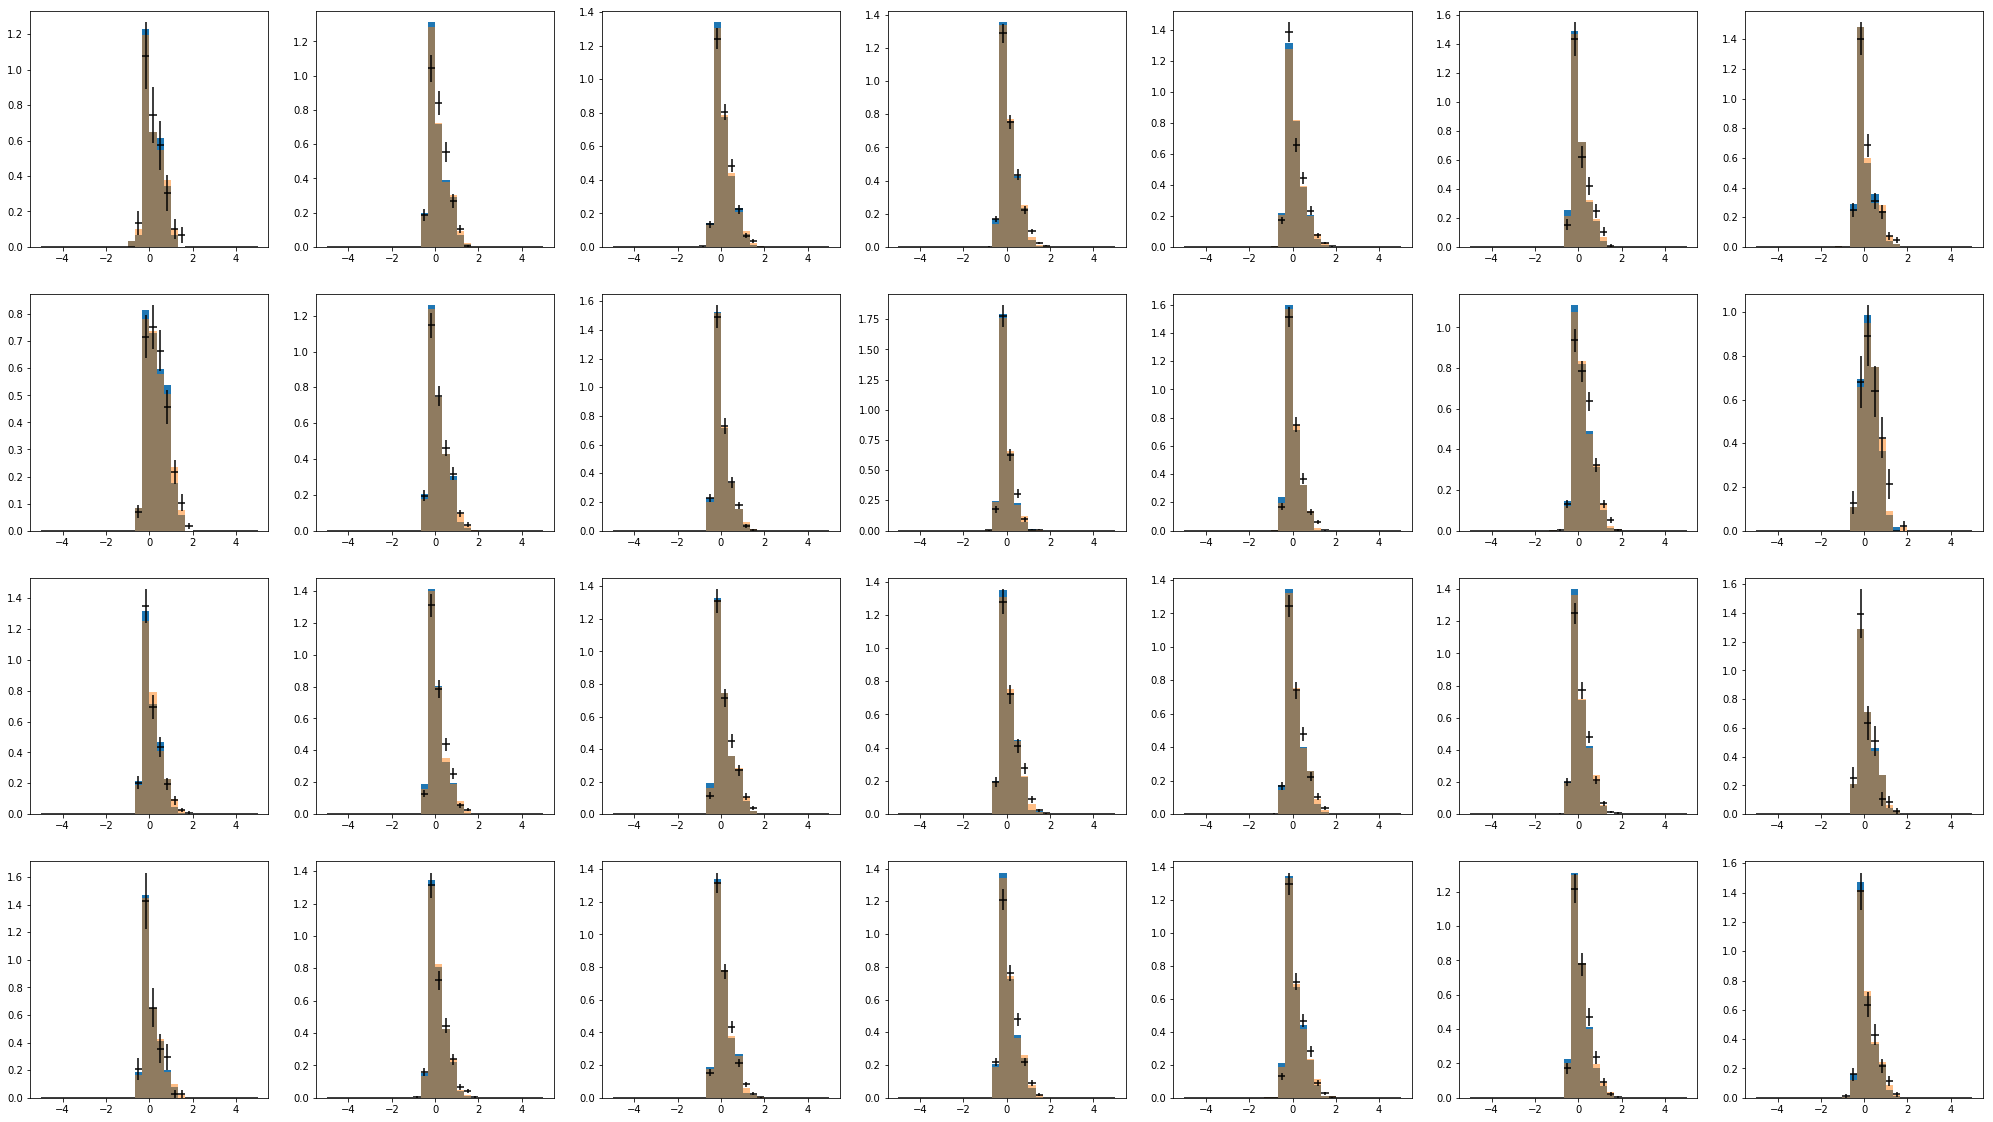

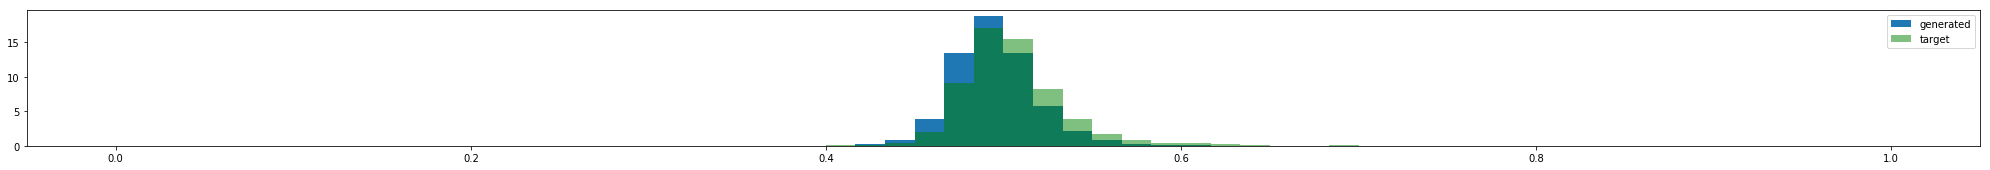

13140/13140 [==============================] - 80s - loss: 2.7739 - generator_loss: 1.3942 - generator_model_2_loss: 0.6948 - generator_D_256x5_output_loss: 0.6994 - discriminator_loss: 1.3797 - discriminator_model_2_loss: 0.6920 - discriminator_D_256x5_output_loss: 0.6877    
Epoch 2/10
13140/13140 [==============================] - 0s - loss: 2.7829 - generator_loss: 1.4135 - generator_model_2_loss: 0.7020 - generator_D_256x5_output_loss: 0.7115 - discriminator_loss: 1.3694 - discriminator_model_2_loss: 0.6886 - discriminator_D_256x5_output_loss: 0.6808     
Epoch 3/10
13140/13140 [==============================] - 0s - loss: 2.7933 - generator_loss: 1.4238 - generator_model_2_loss: 0.7121 - generator_D_256x5_output_loss: 0.7117 - discriminator_loss: 1.3695 - discriminator_model_2_loss: 0.6835 - discriminator_D_256x5_output_loss: 0.6860     
Epoch 4/10
13140/13140 [==============================] - 0s - loss: 2.7967 - generator_loss: 1.4263 - generator_model_2_loss: 0.7101 - generato

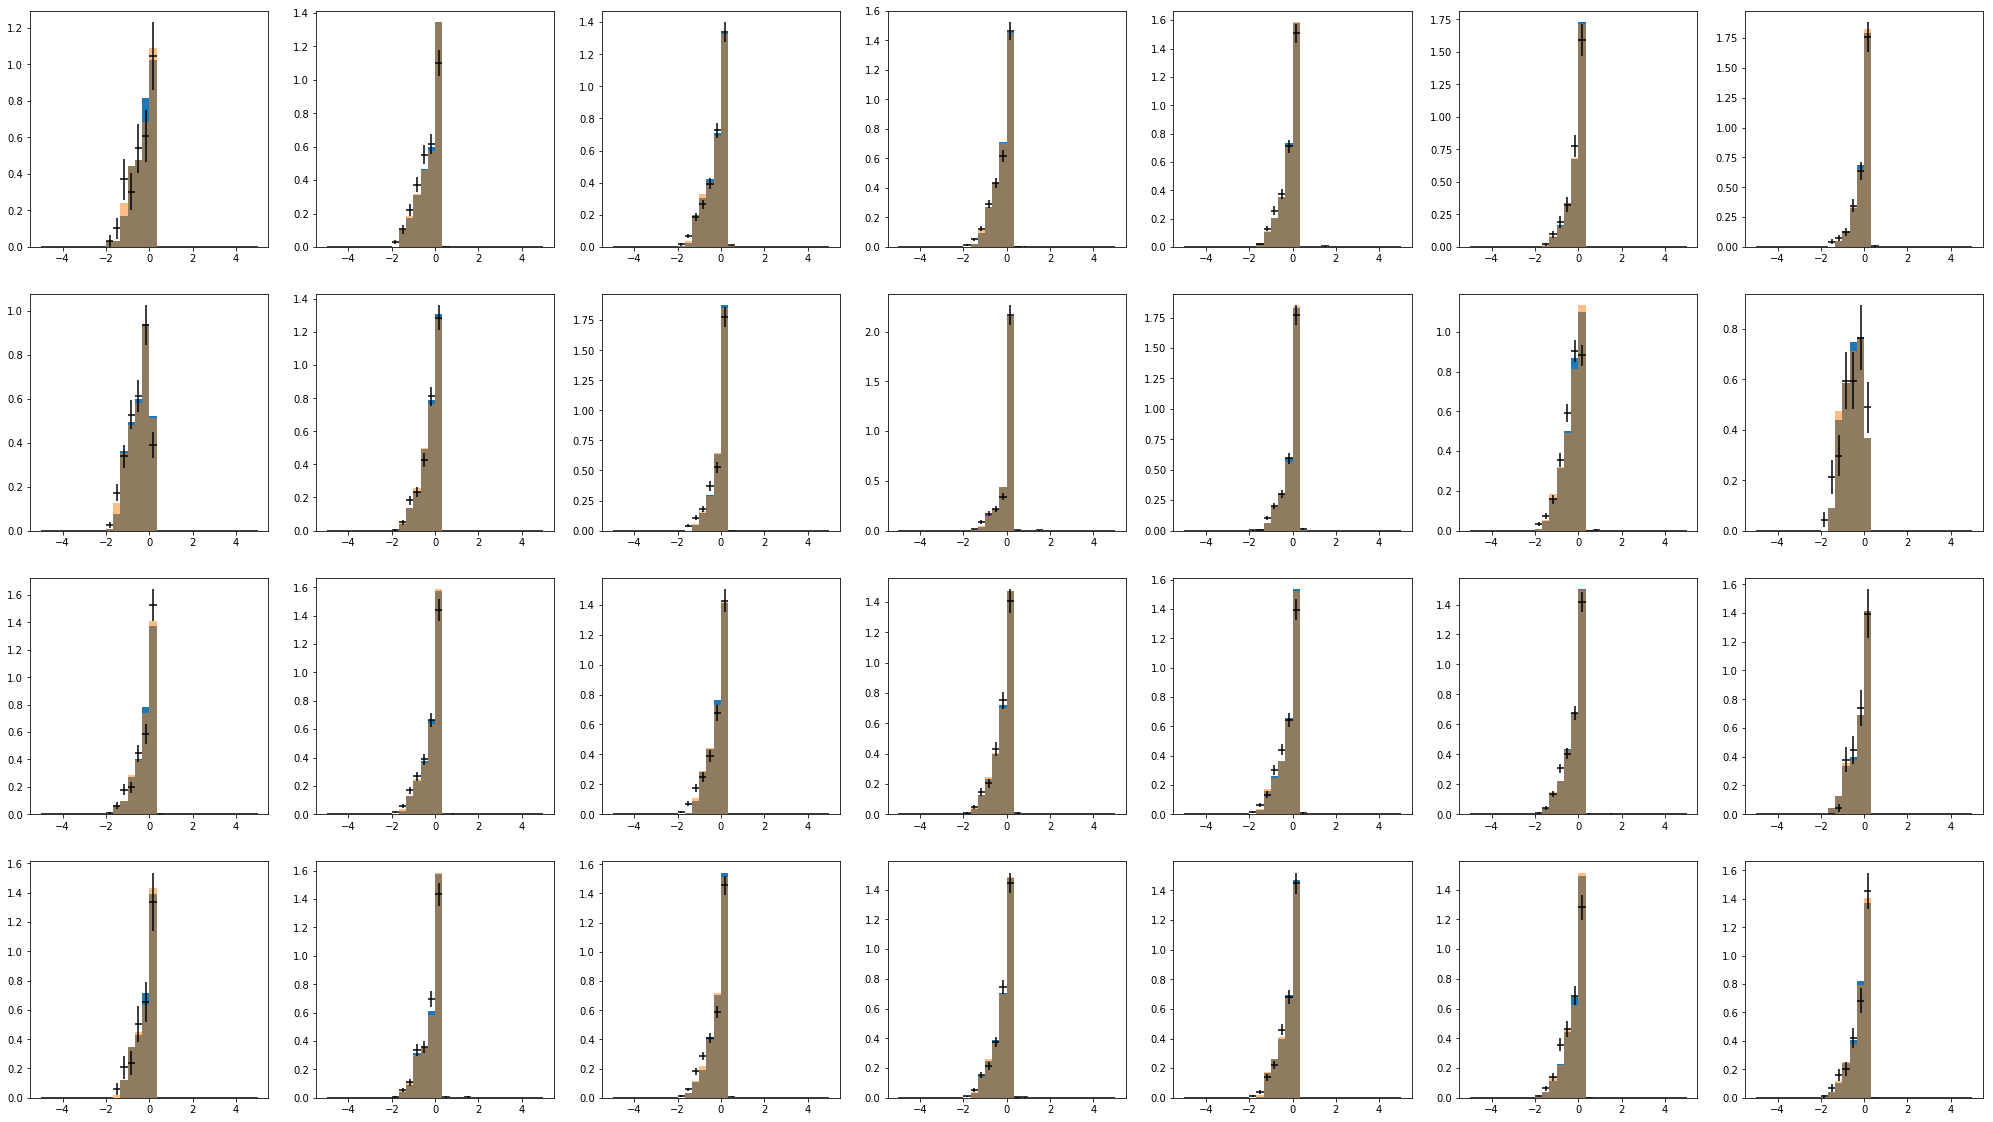

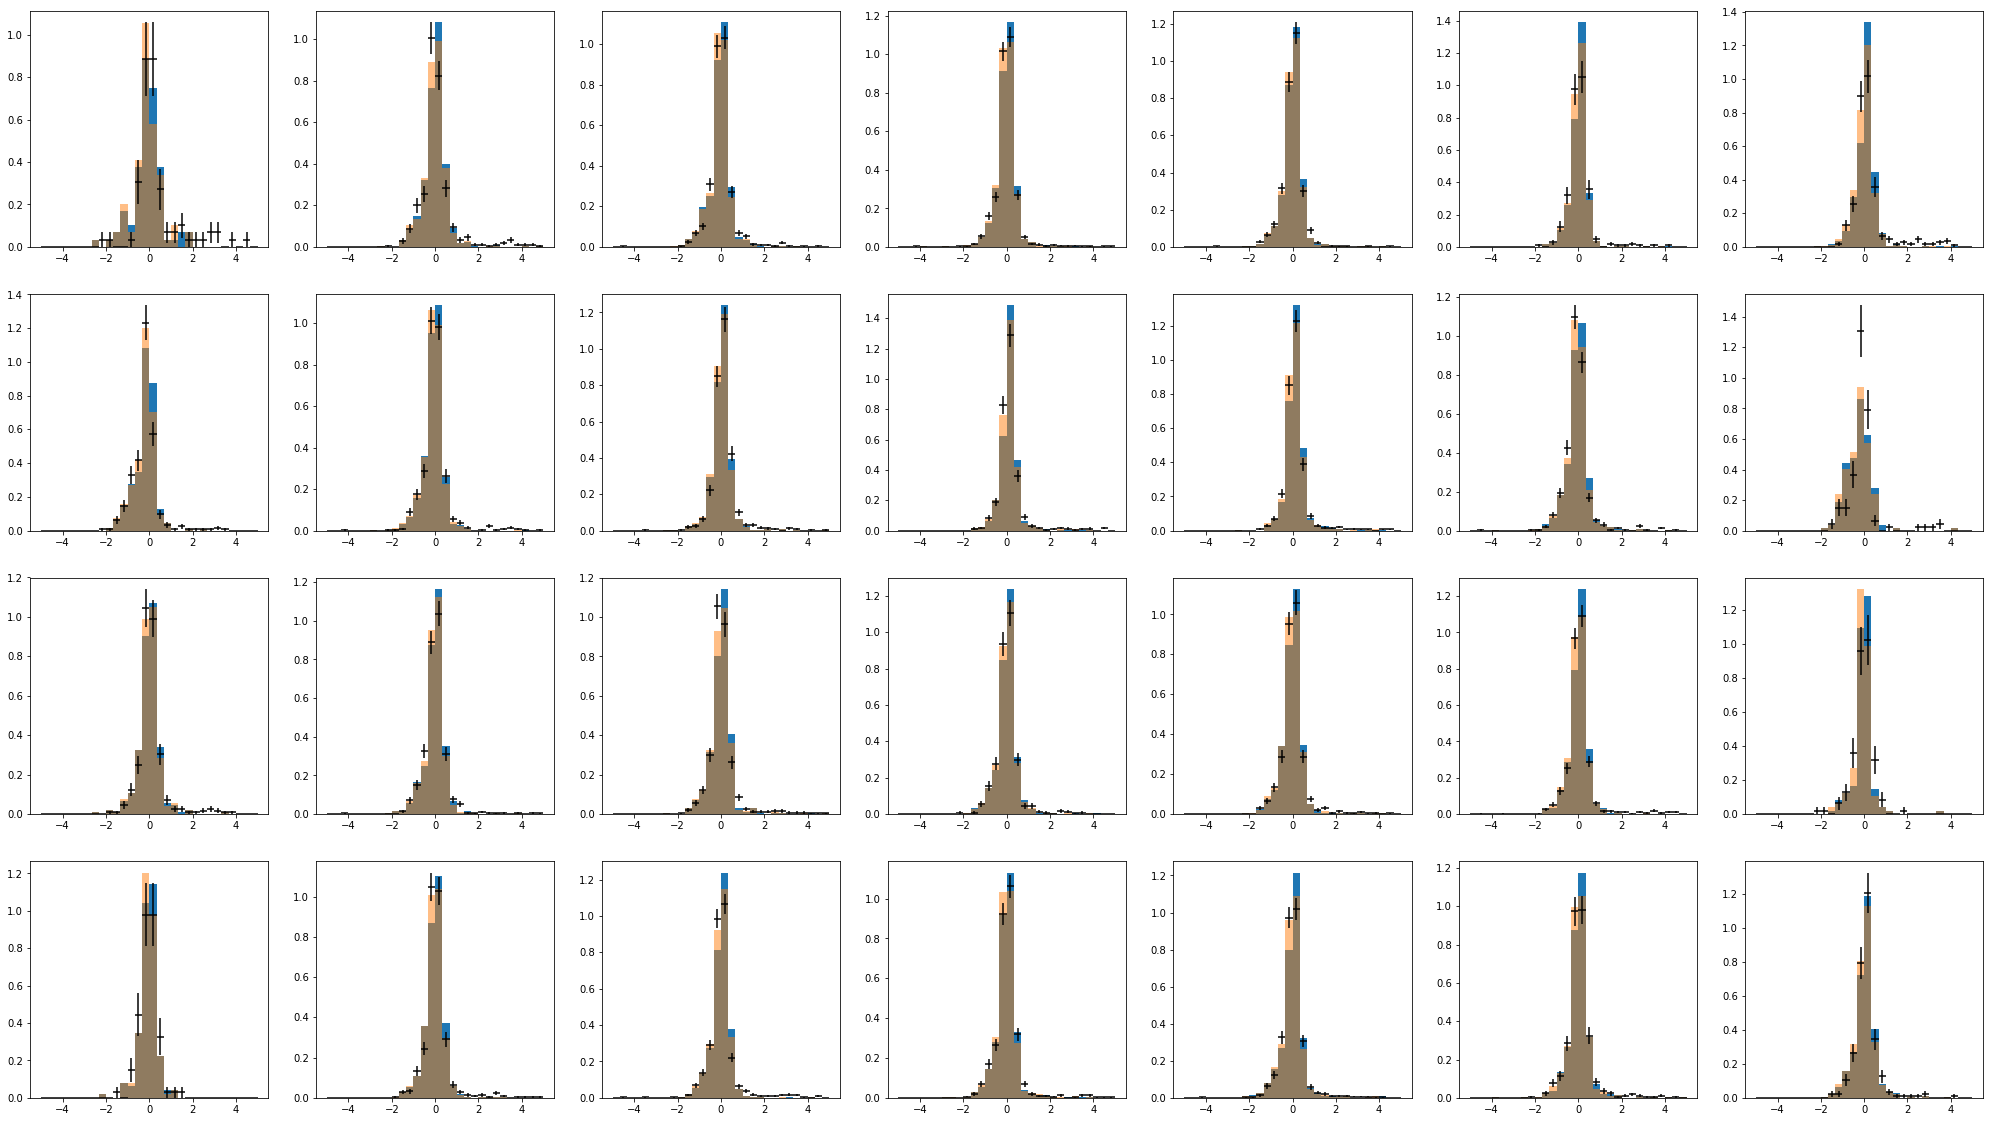

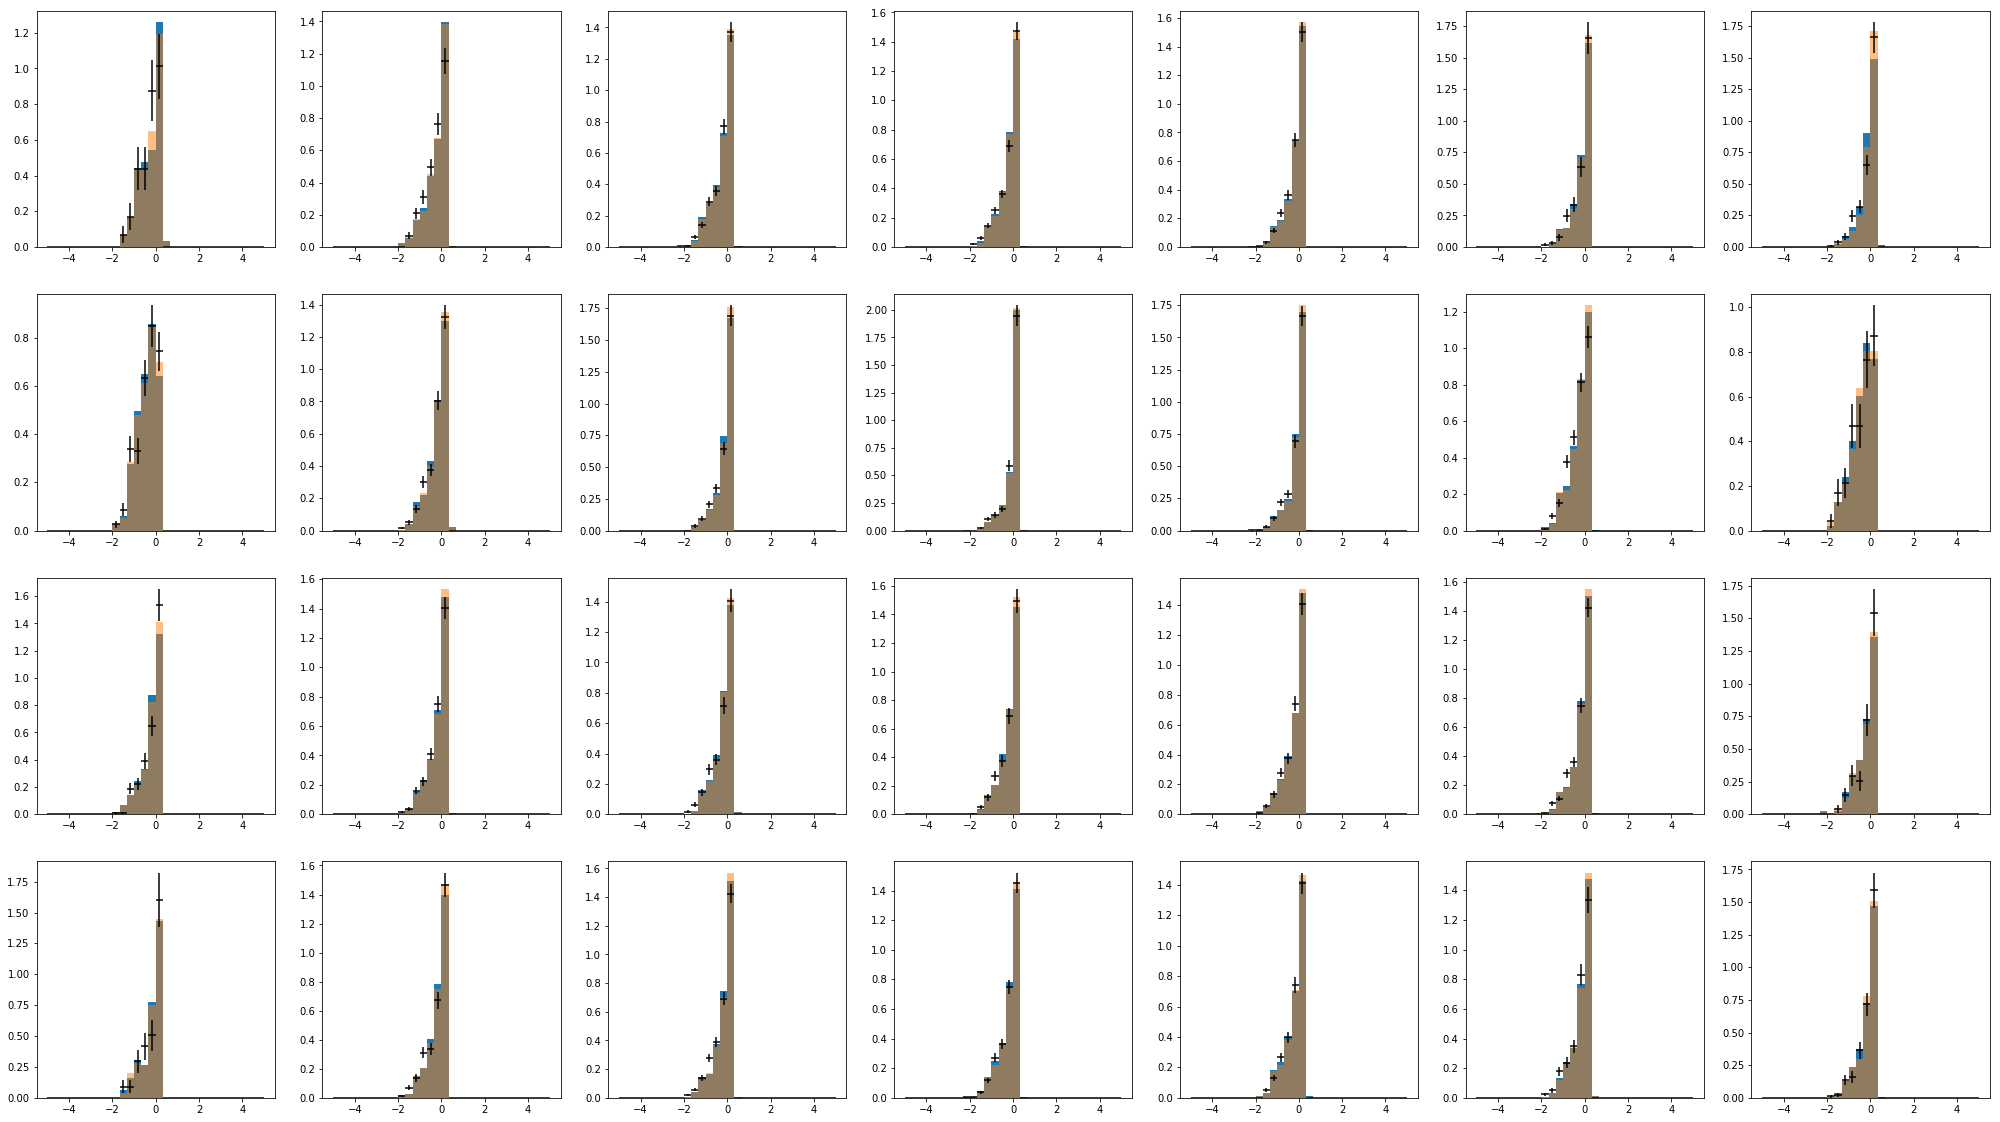

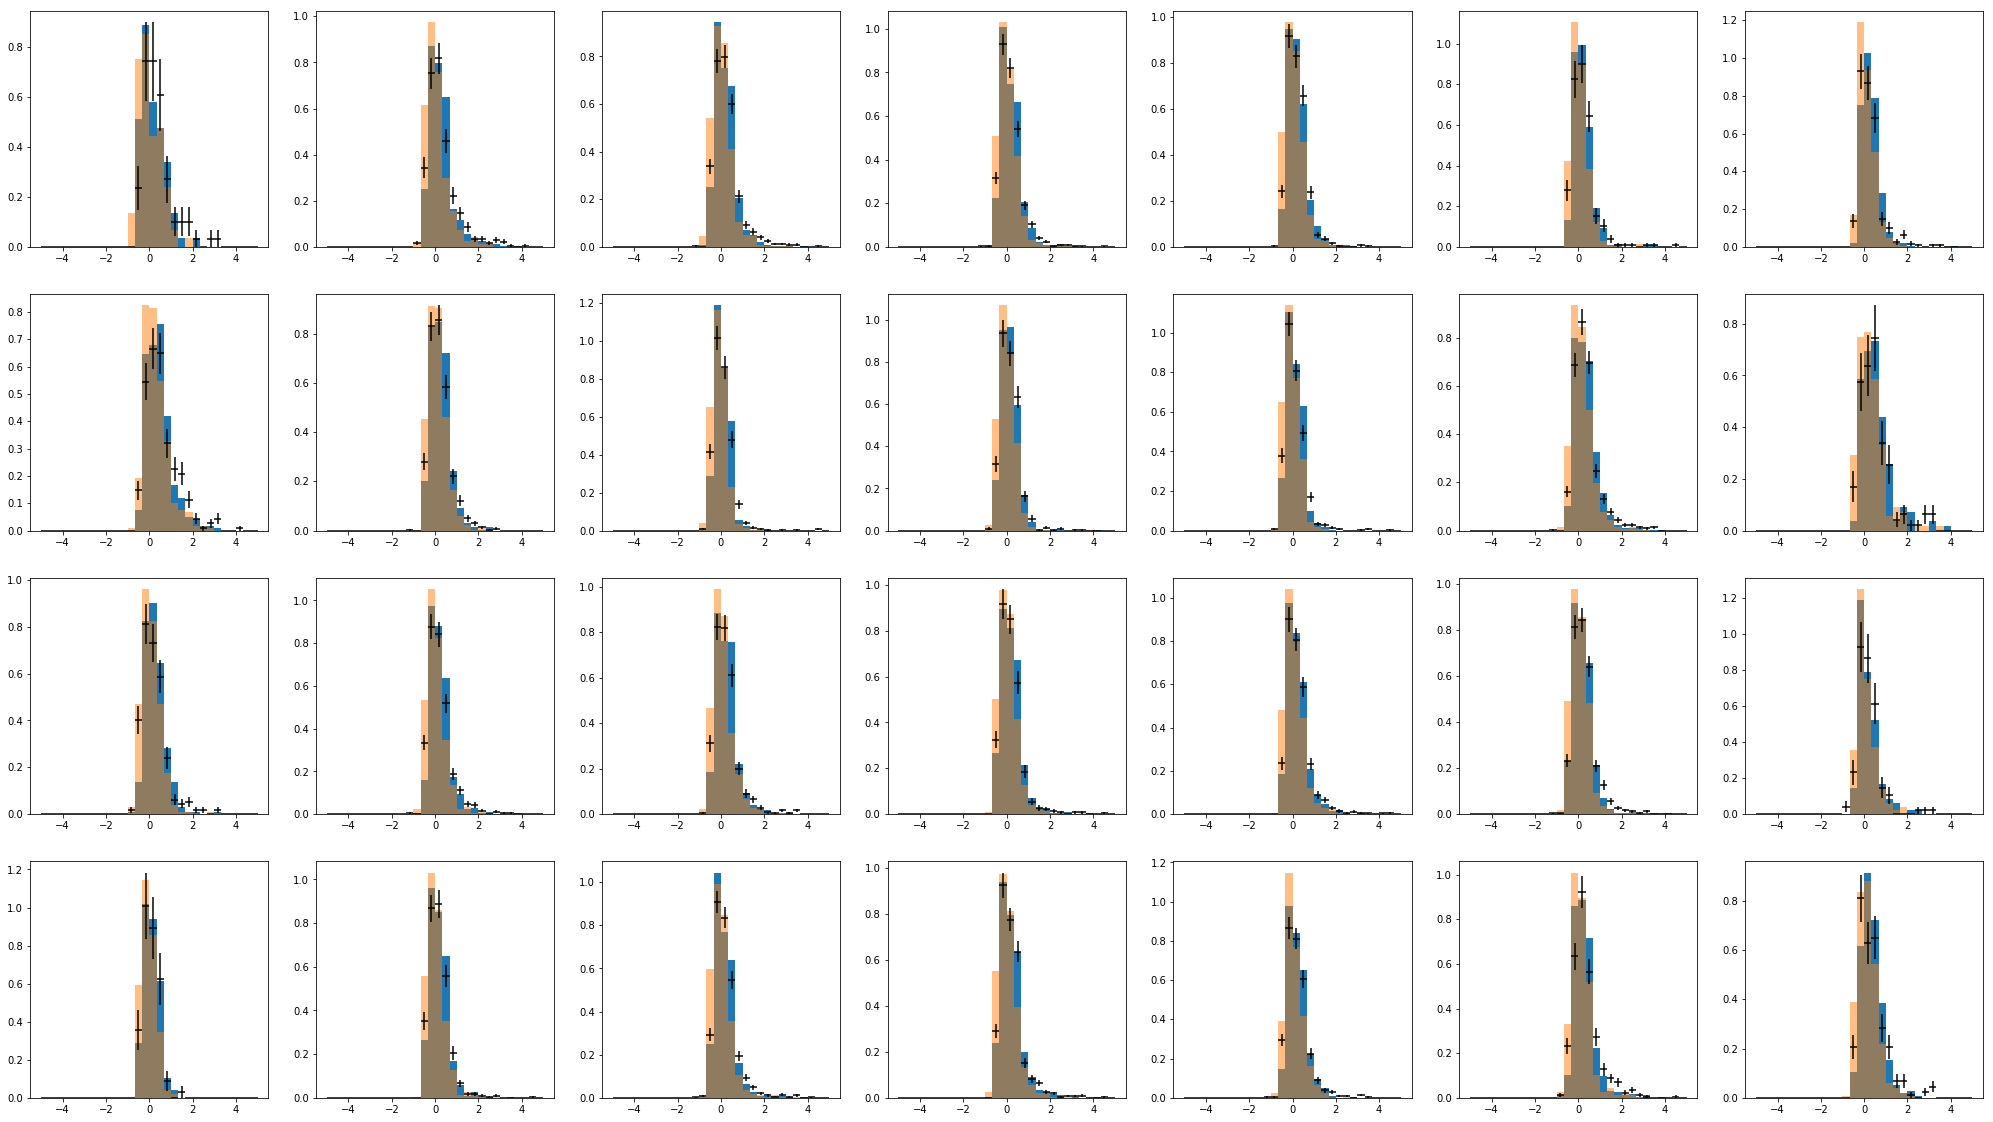

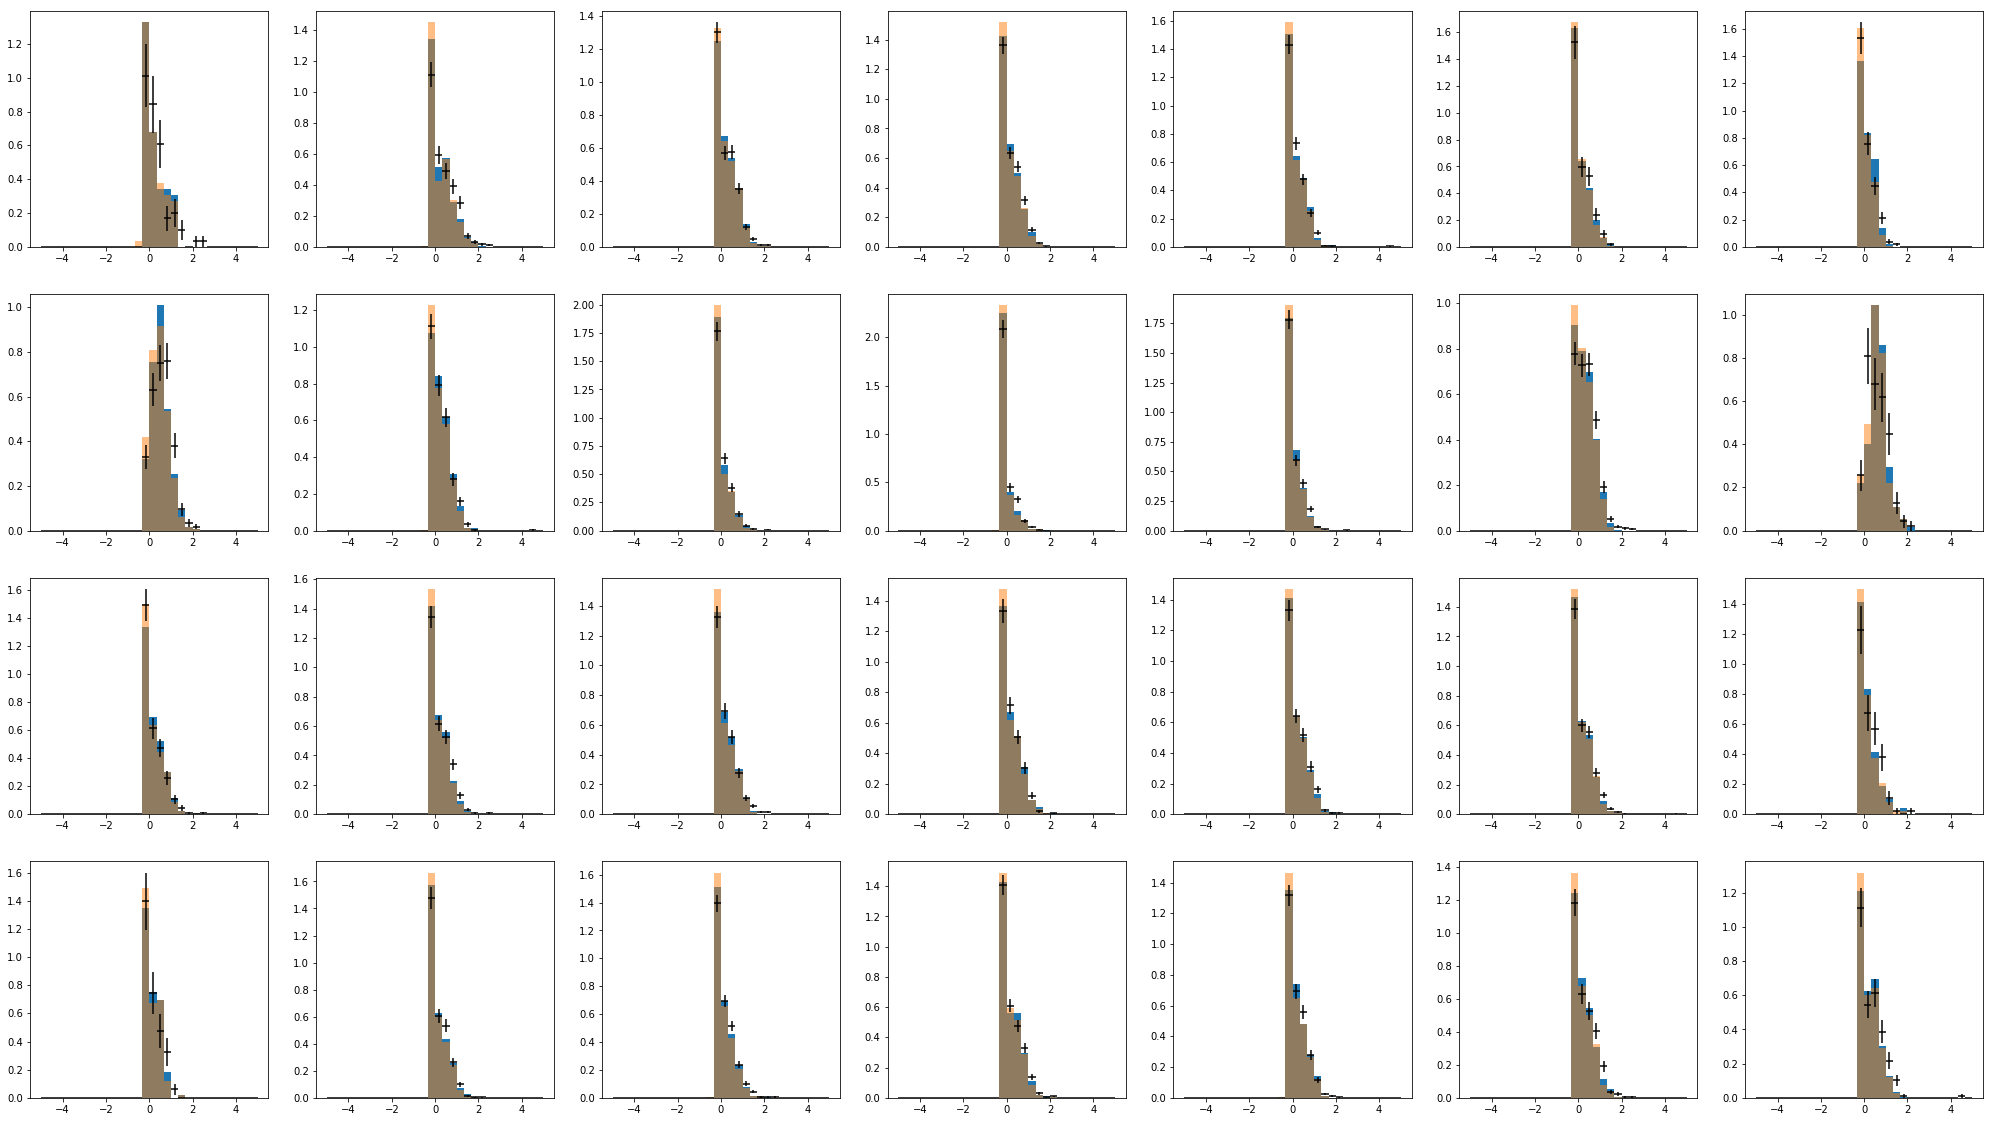

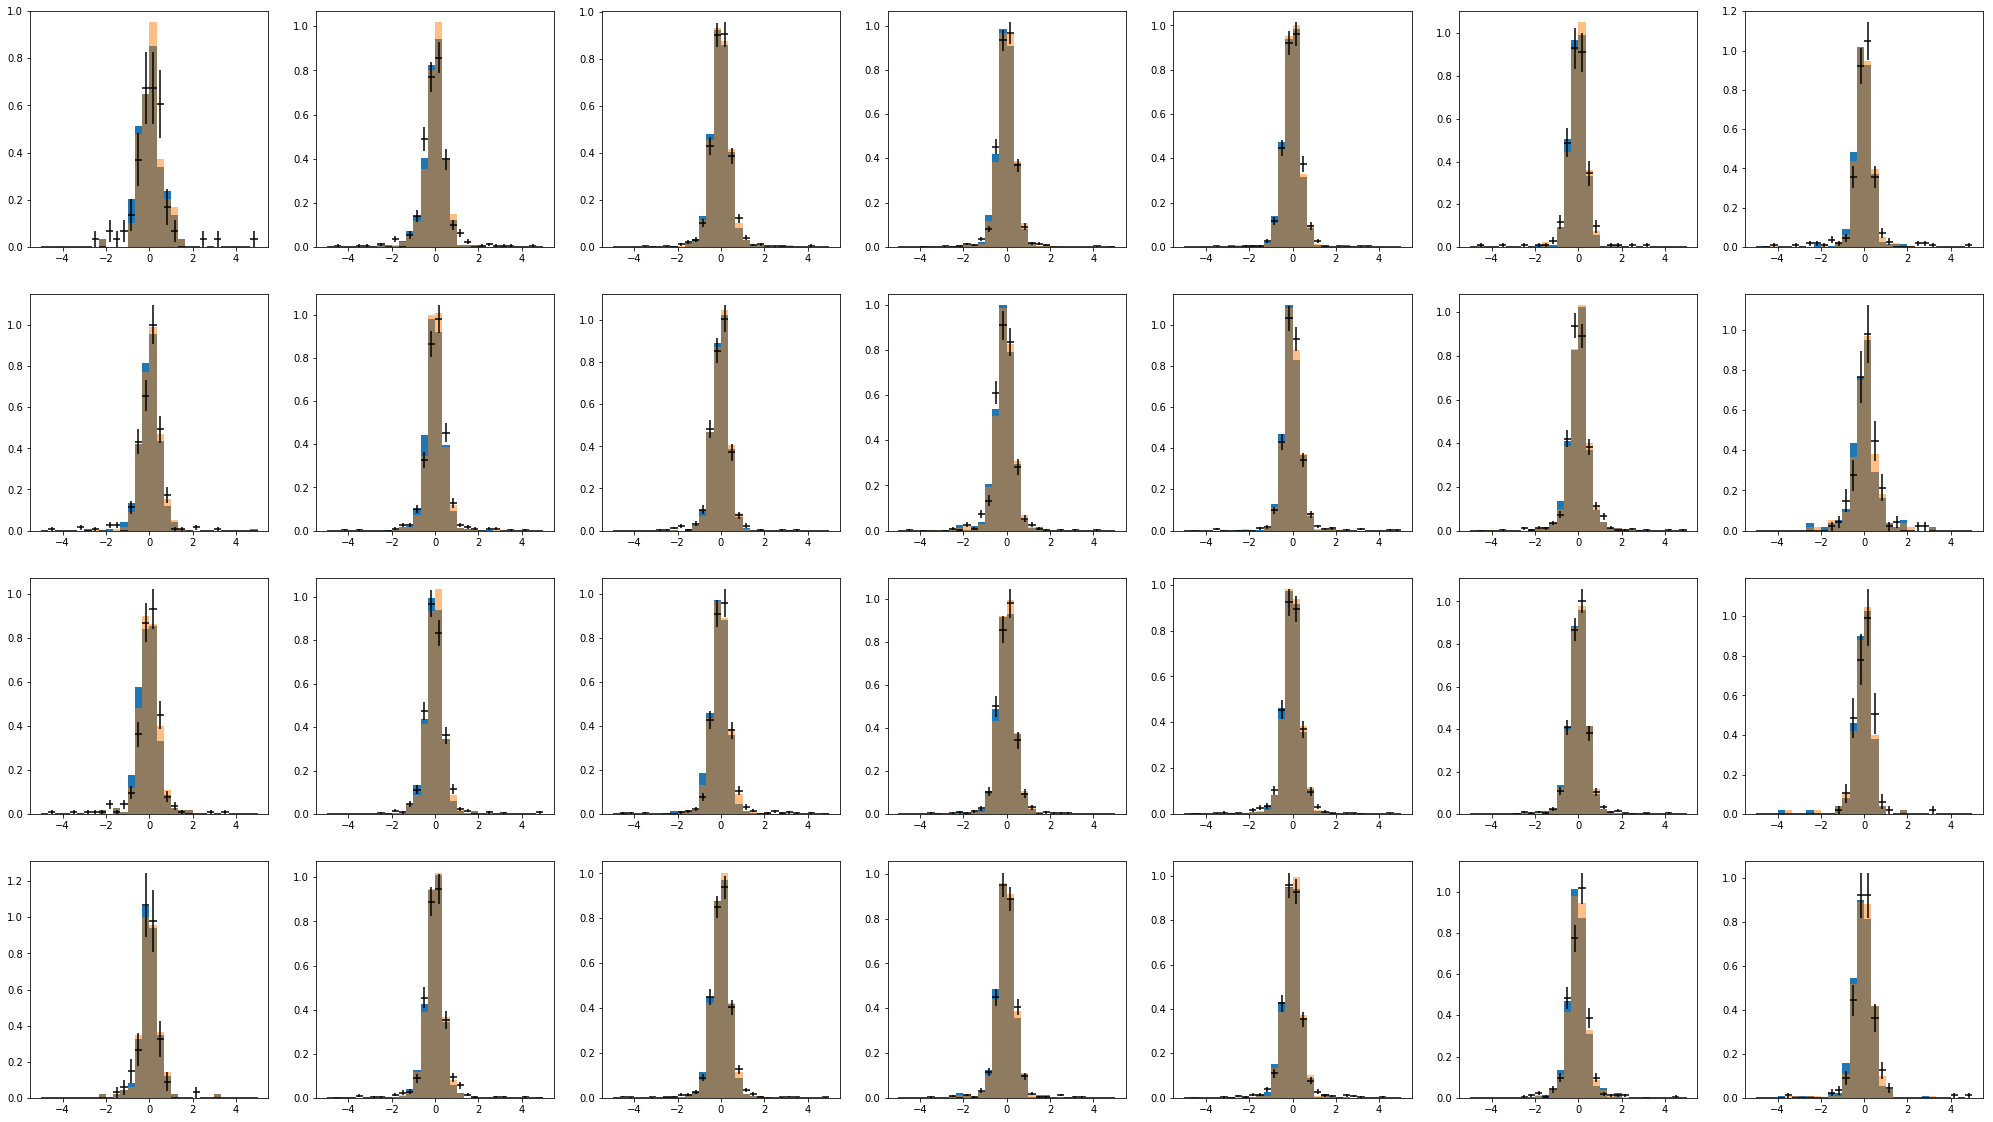

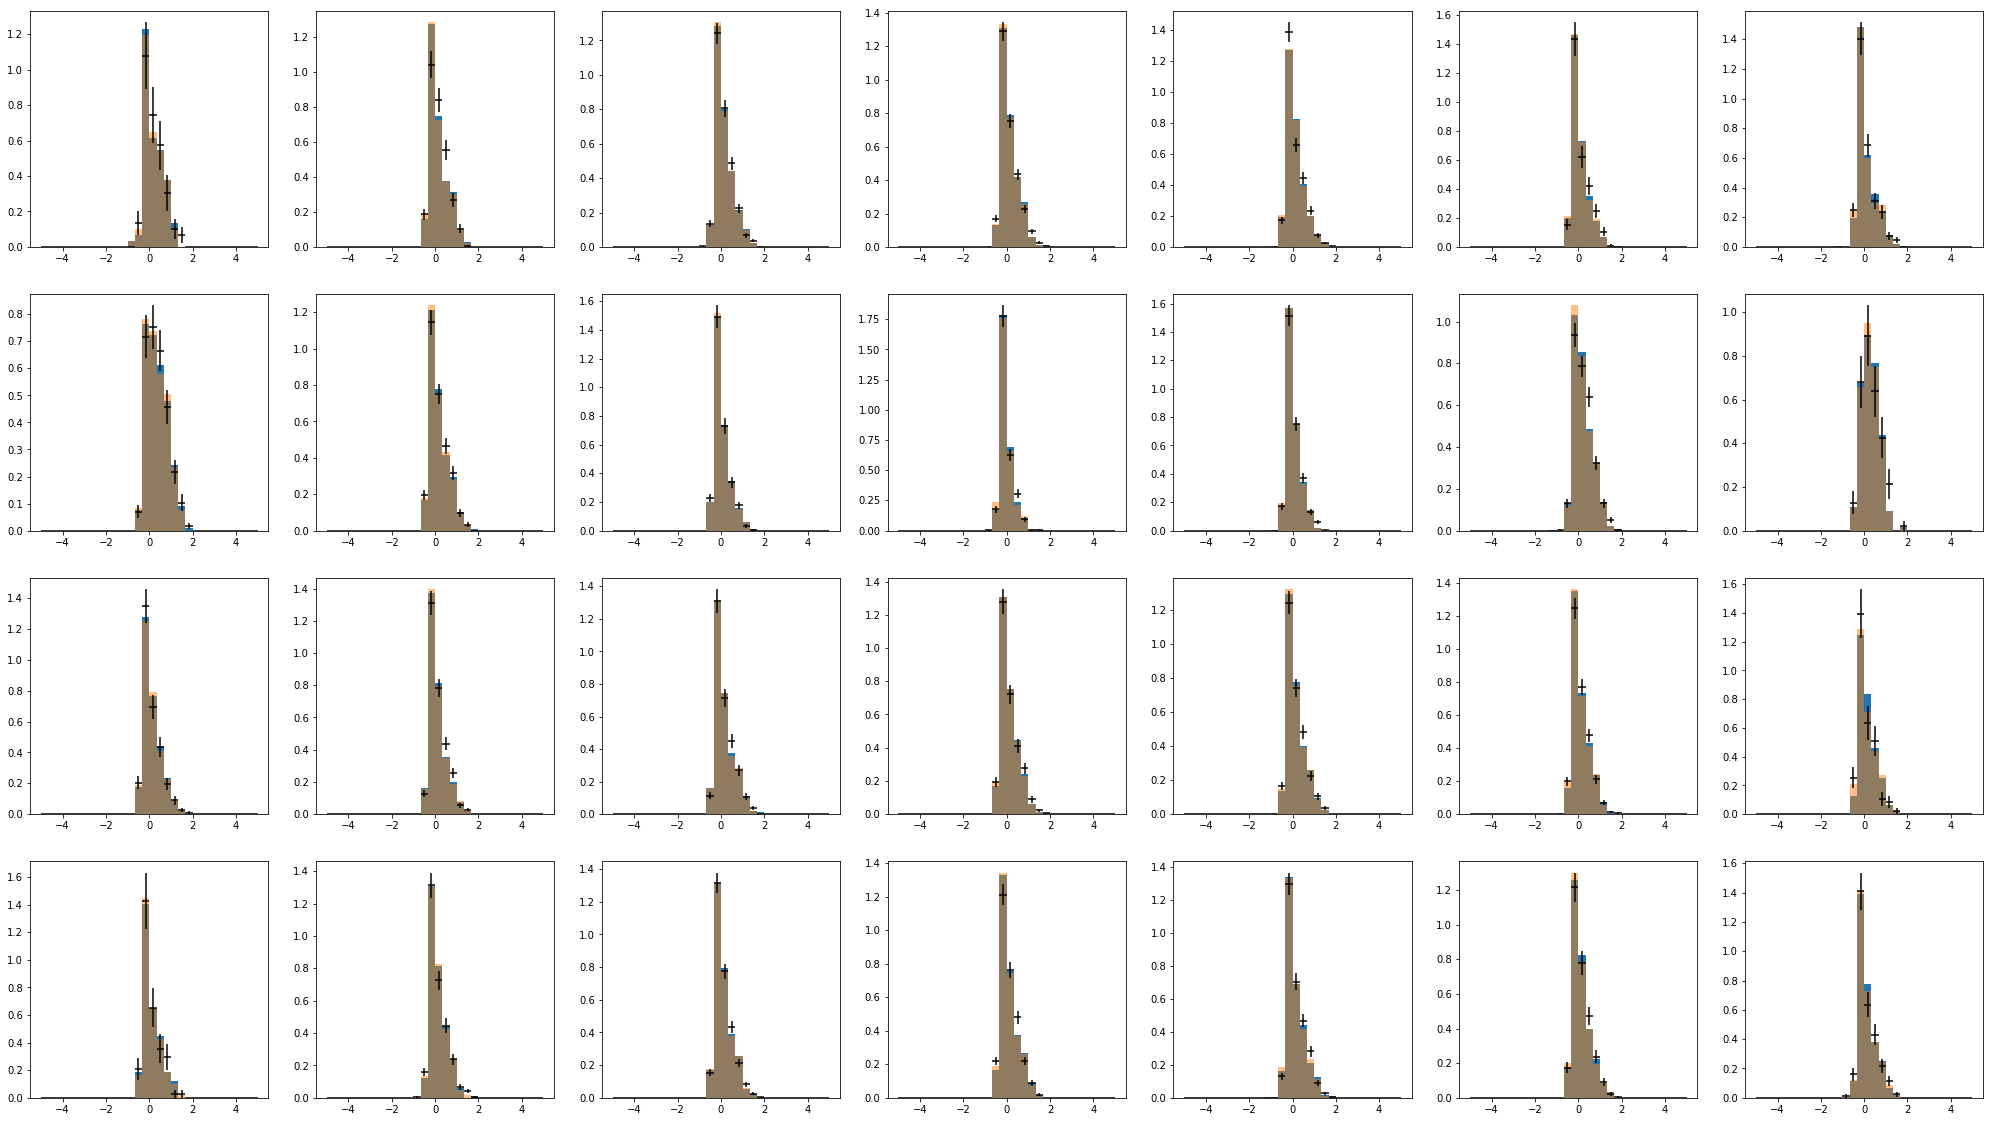

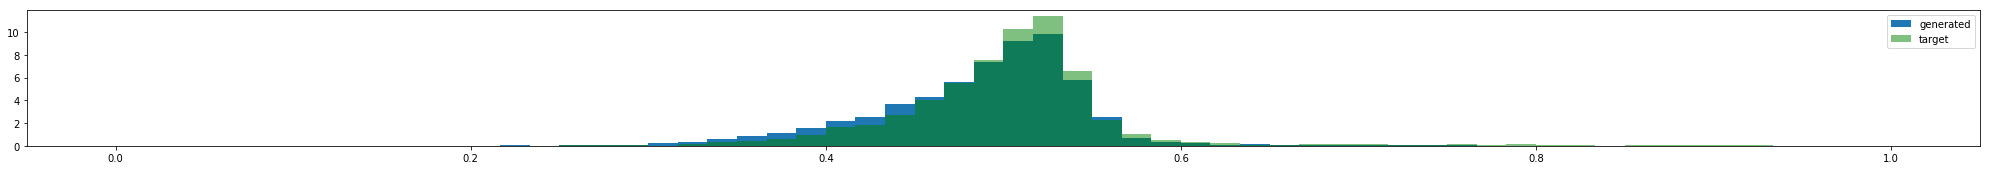

13140/13140 [==============================] - 74s - loss: 2.8031 - generator_loss: 1.4361 - generator_model_2_loss: 0.7209 - generator_D_256x5_output_loss: 0.7152 - discriminator_loss: 1.3670 - discriminator_model_2_loss: 0.6792 - discriminator_D_256x5_output_loss: 0.6879    
Epoch 7/10
13140/13140 [==============================] - 0s - loss: 2.8066 - generator_loss: 1.4424 - generator_model_2_loss: 0.7258 - generator_D_256x5_output_loss: 0.7165 - discriminator_loss: 1.3643 - discriminator_model_2_loss: 0.6764 - discriminator_D_256x5_output_loss: 0.6879     
Epoch 8/10
13140/13140 [==============================] - 0s - loss: 2.8055 - generator_loss: 1.4415 - generator_model_2_loss: 0.7280 - generator_D_256x5_output_loss: 0.7135 - discriminator_loss: 1.3640 - discriminator_model_2_loss: 0.6743 - discriminator_D_256x5_output_loss: 0.6896     
Epoch 9/10
13140/13140 [==============================] - 0s - loss: 2.8091 - generator_loss: 1.4456 - generator_model_2_loss: 0.7305 - generato

In [26]:
reload(base)

do = dict(
    x_train=data_x_train,
    z_train=mc_x_train,
    c_x_train=data_c_train,
    c_z_train=mc_c_train,
          
    x_test=data_x_test,
    z_test=mc_x_test,
    c_x_test=data_c_test,
    c_z_test=mc_c_test,
    
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    plot_every=PLOT_EVERY,
)

base.MyGAN.adversarial_fit(gan,**do)


In [27]:
mc_x_morphed = gan.get_generator().predict([mc_c_test,mc_x_test])[1]

data_p = gan.get_discriminator().predict([data_c_test,data_x_test])
mc_p   = gan.get_discriminator().predict([mc_c_test,mc_x_morphed])

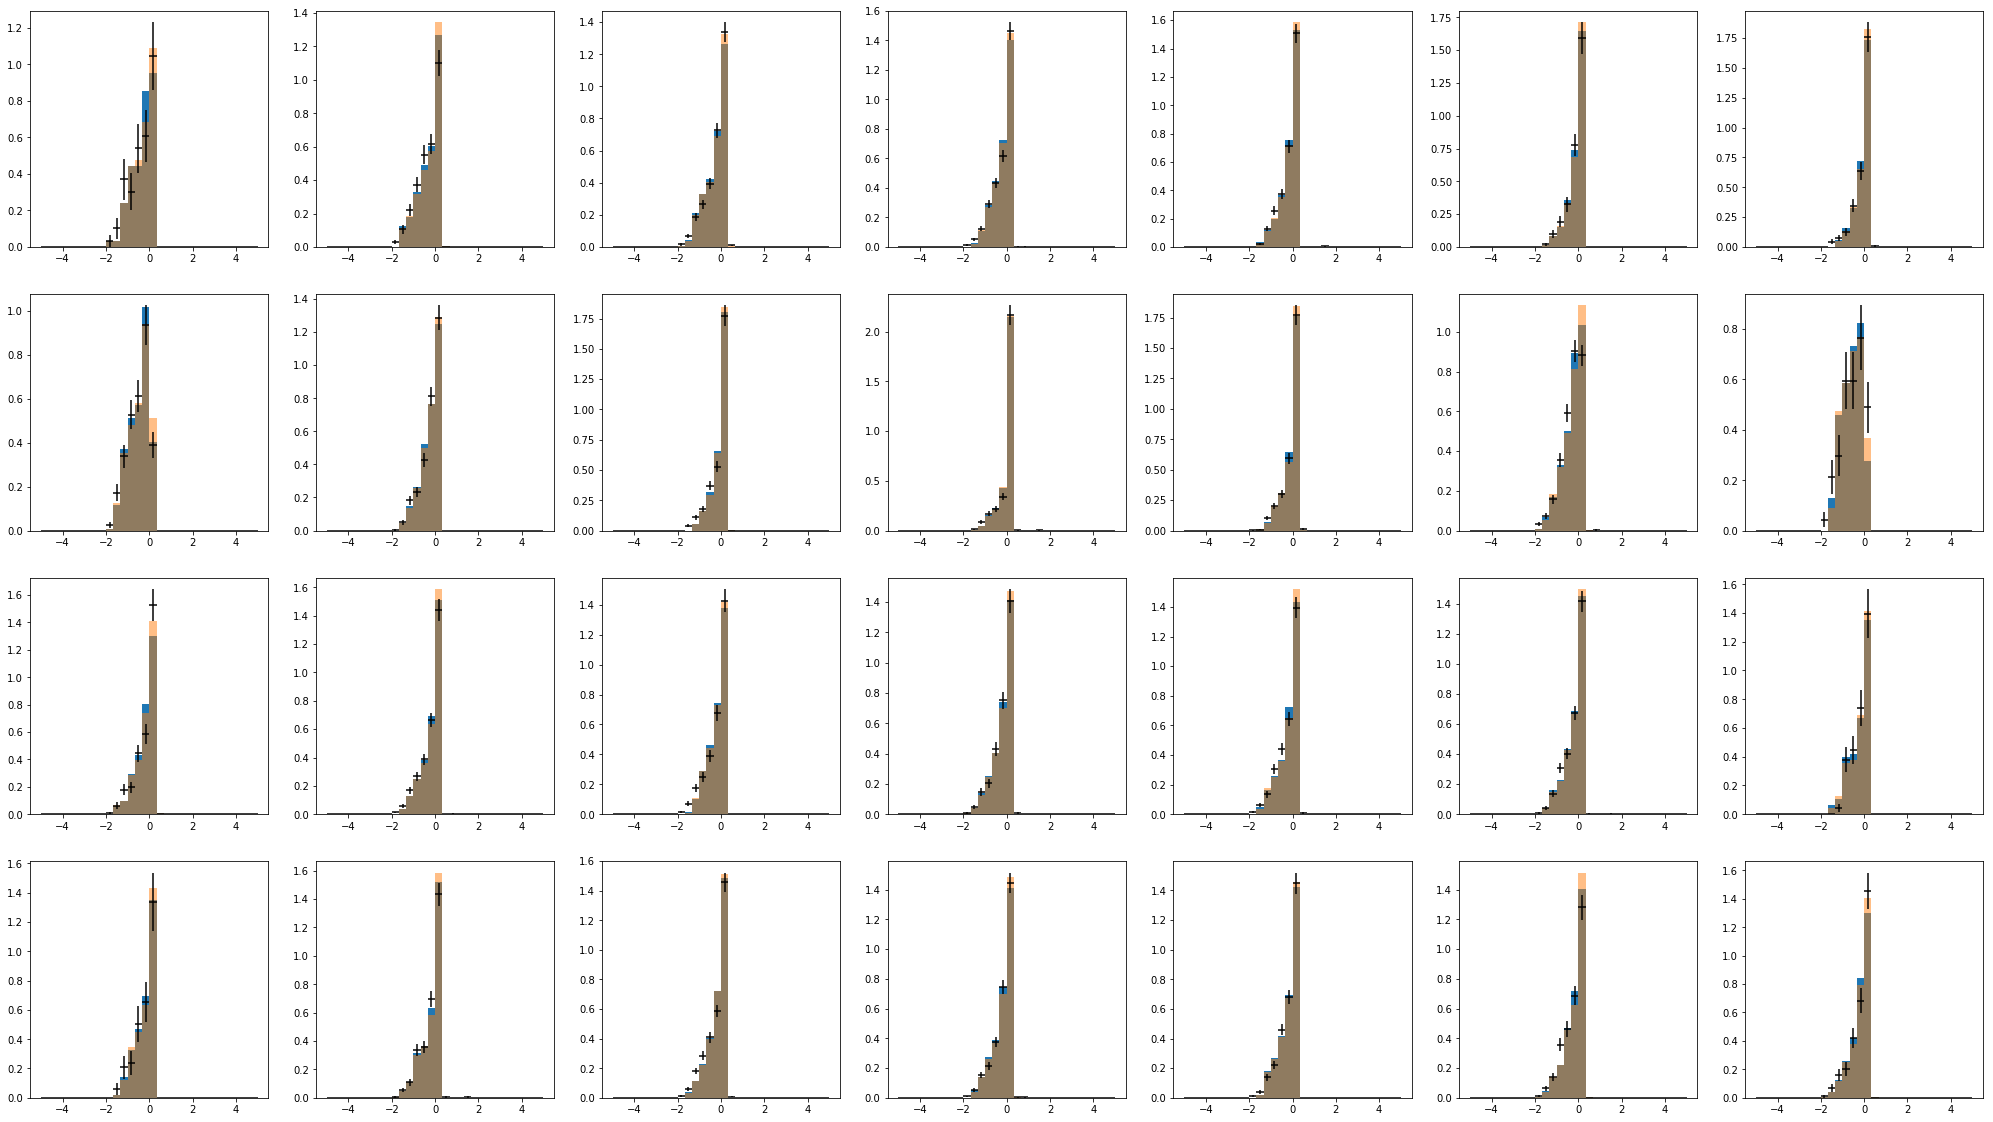

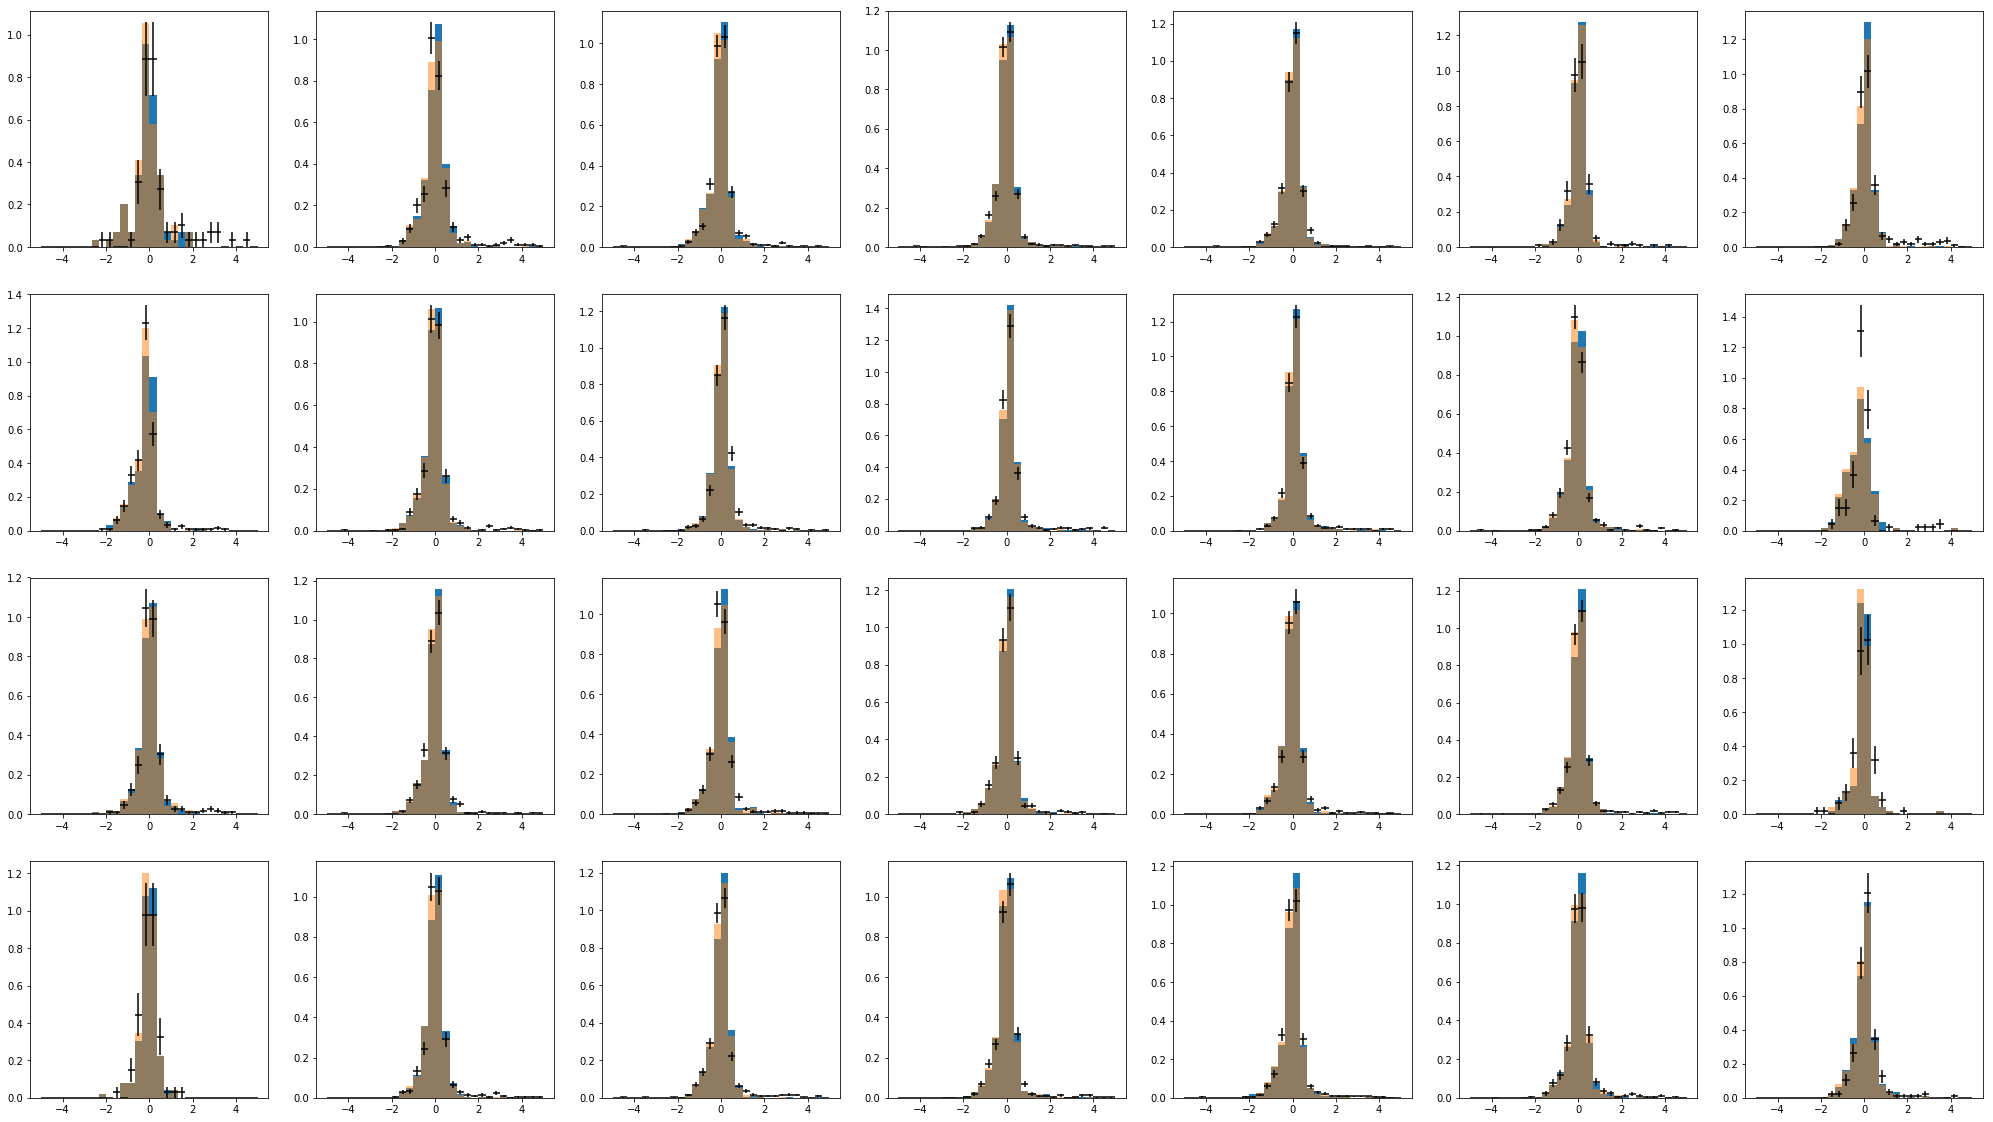

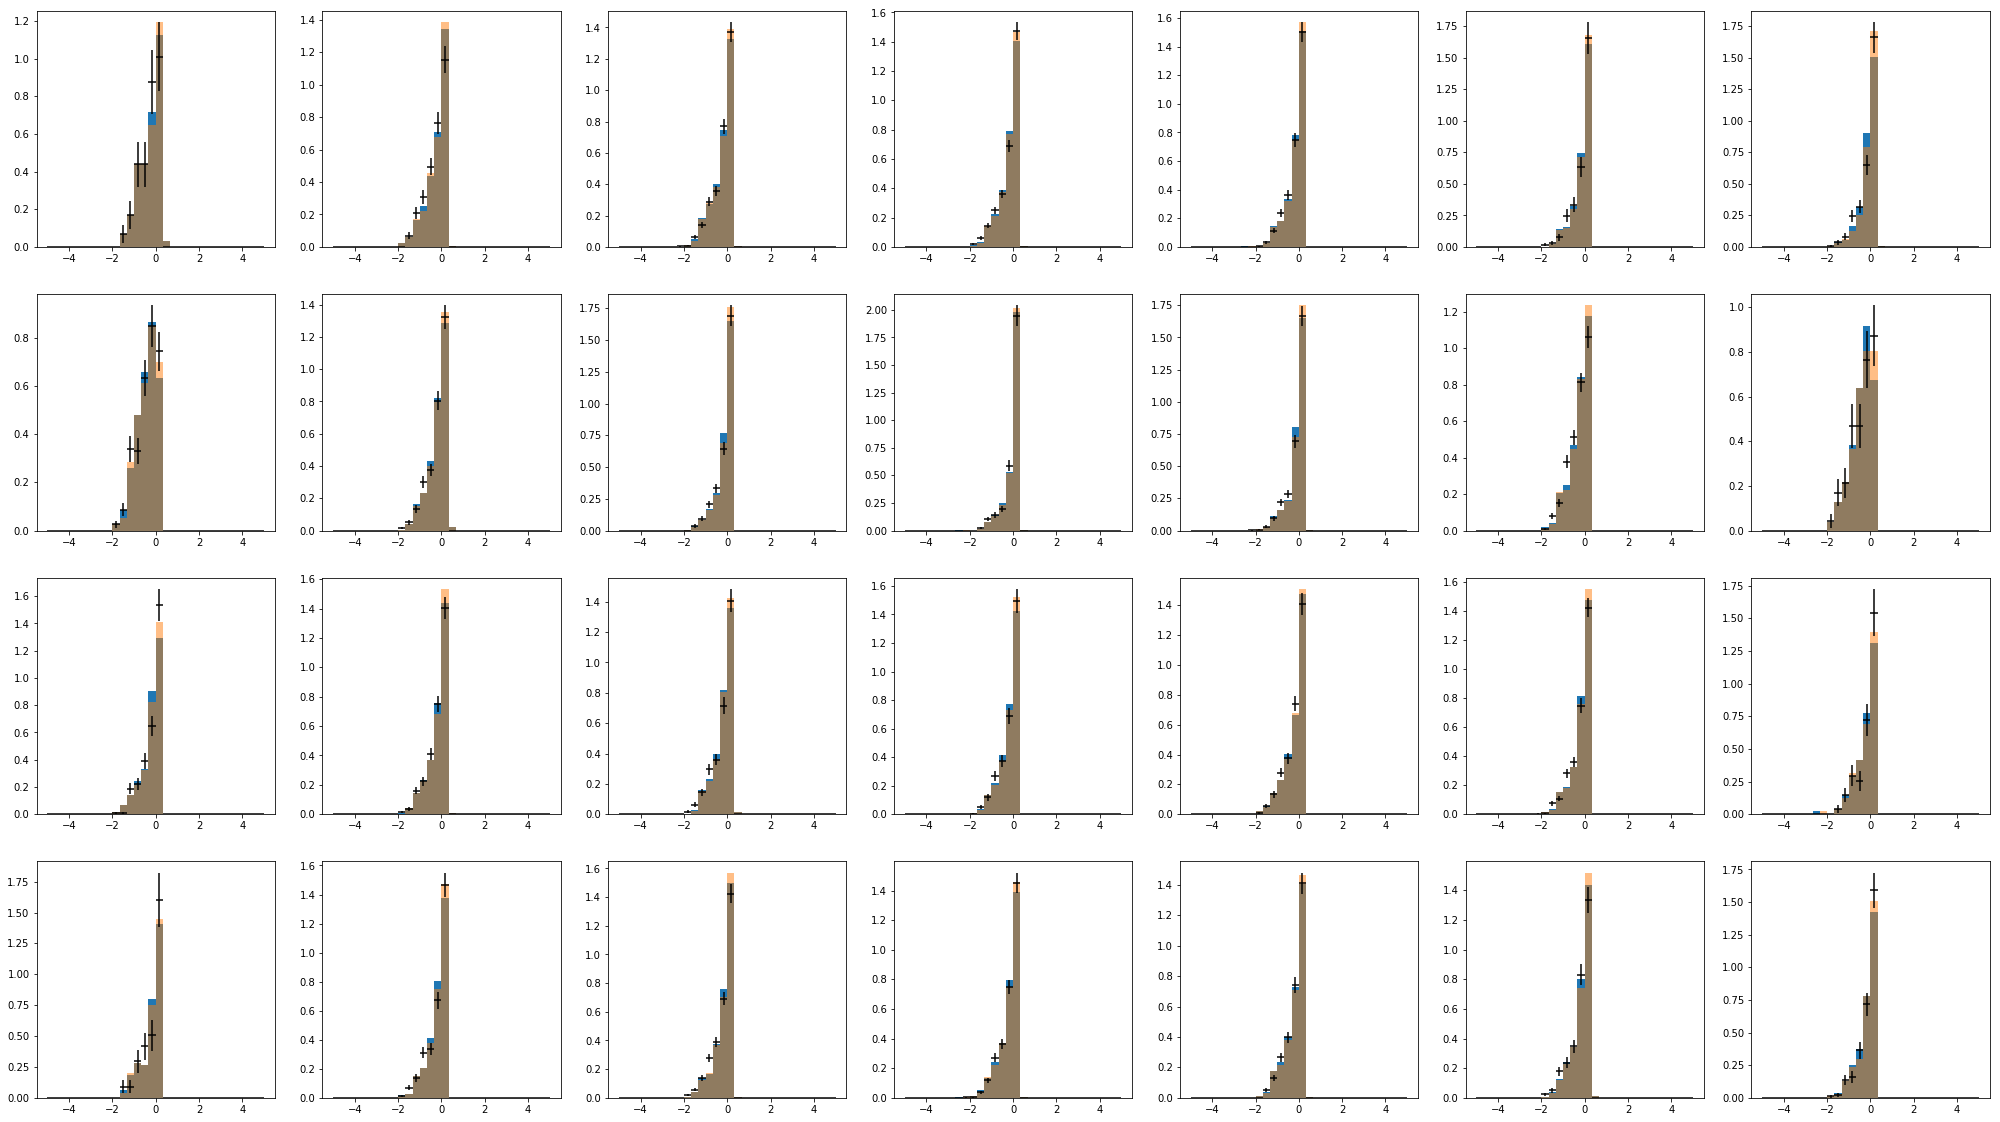

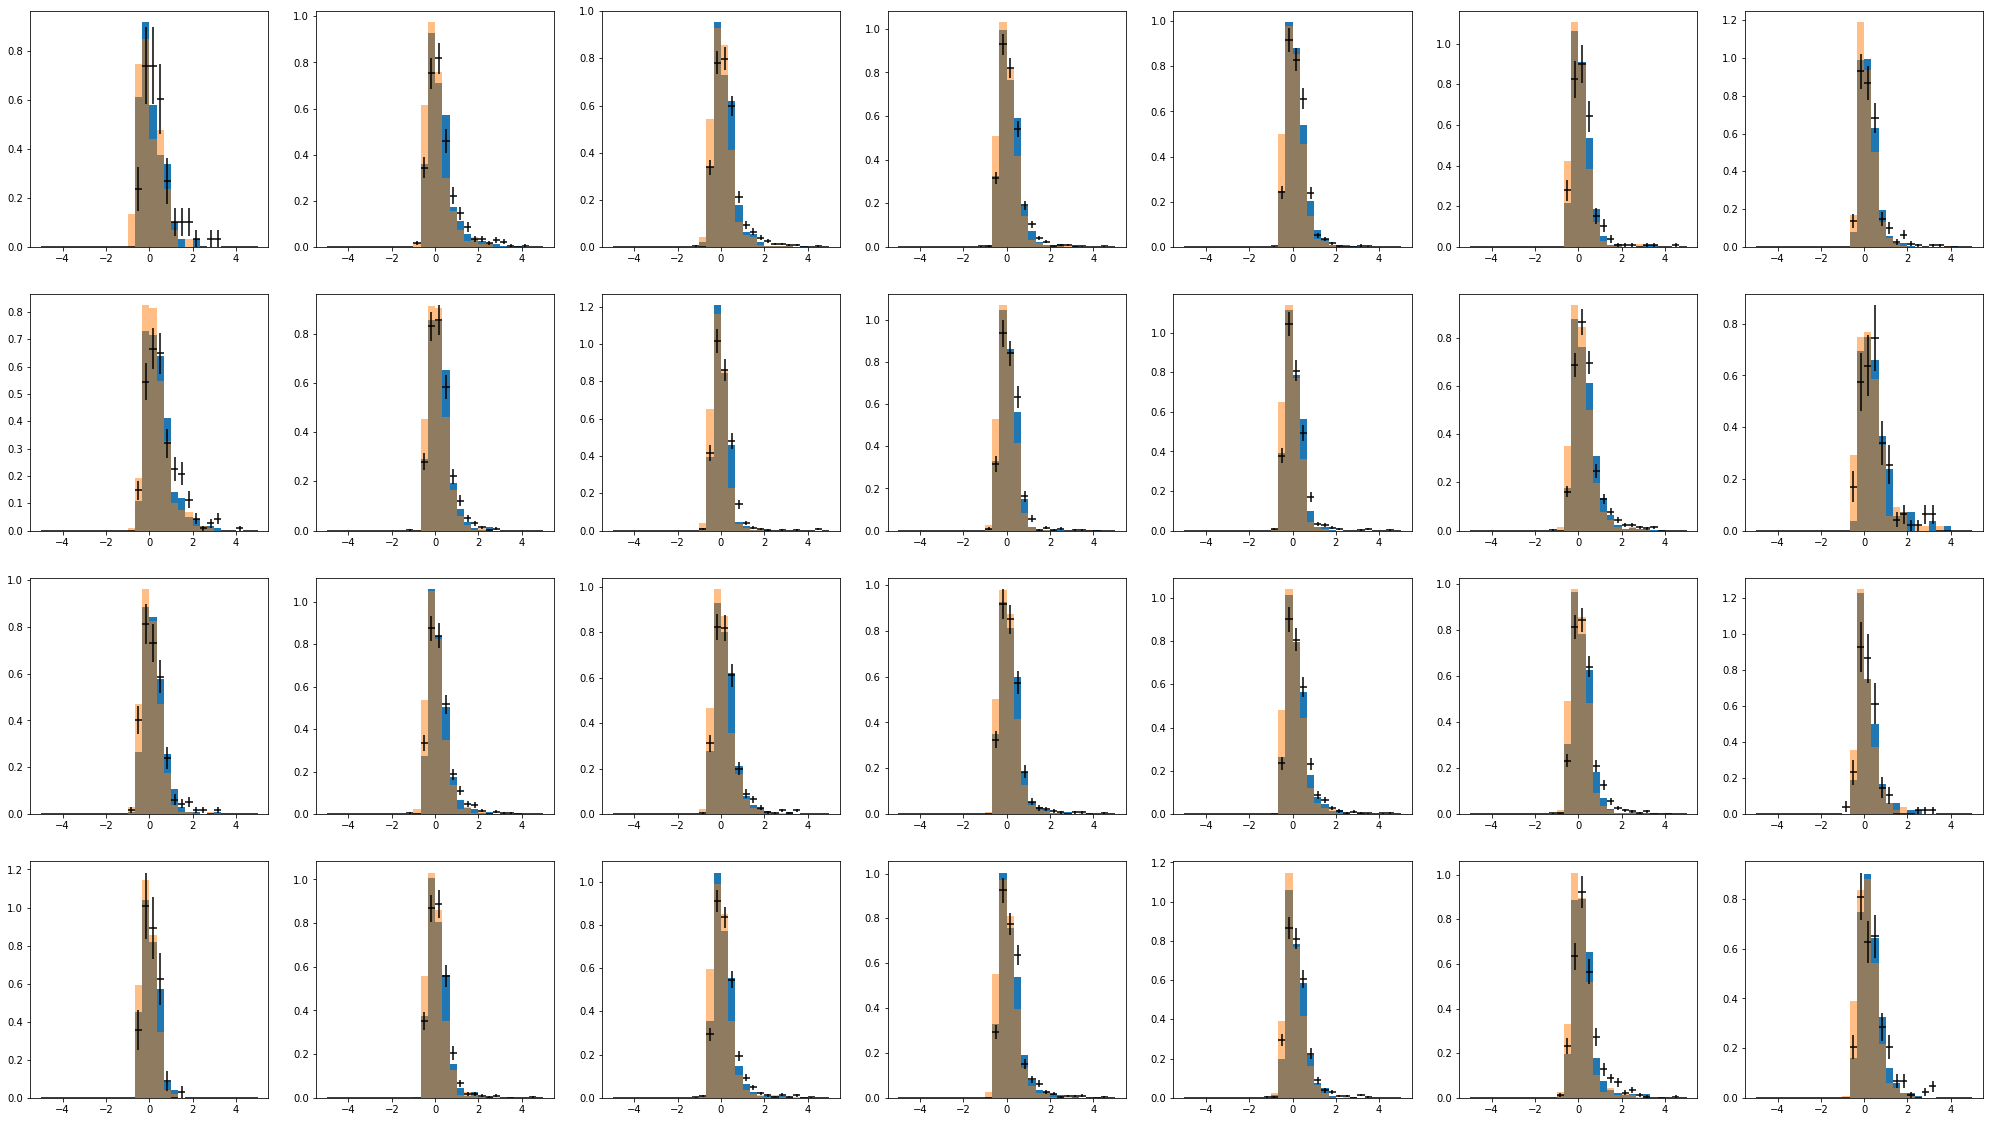

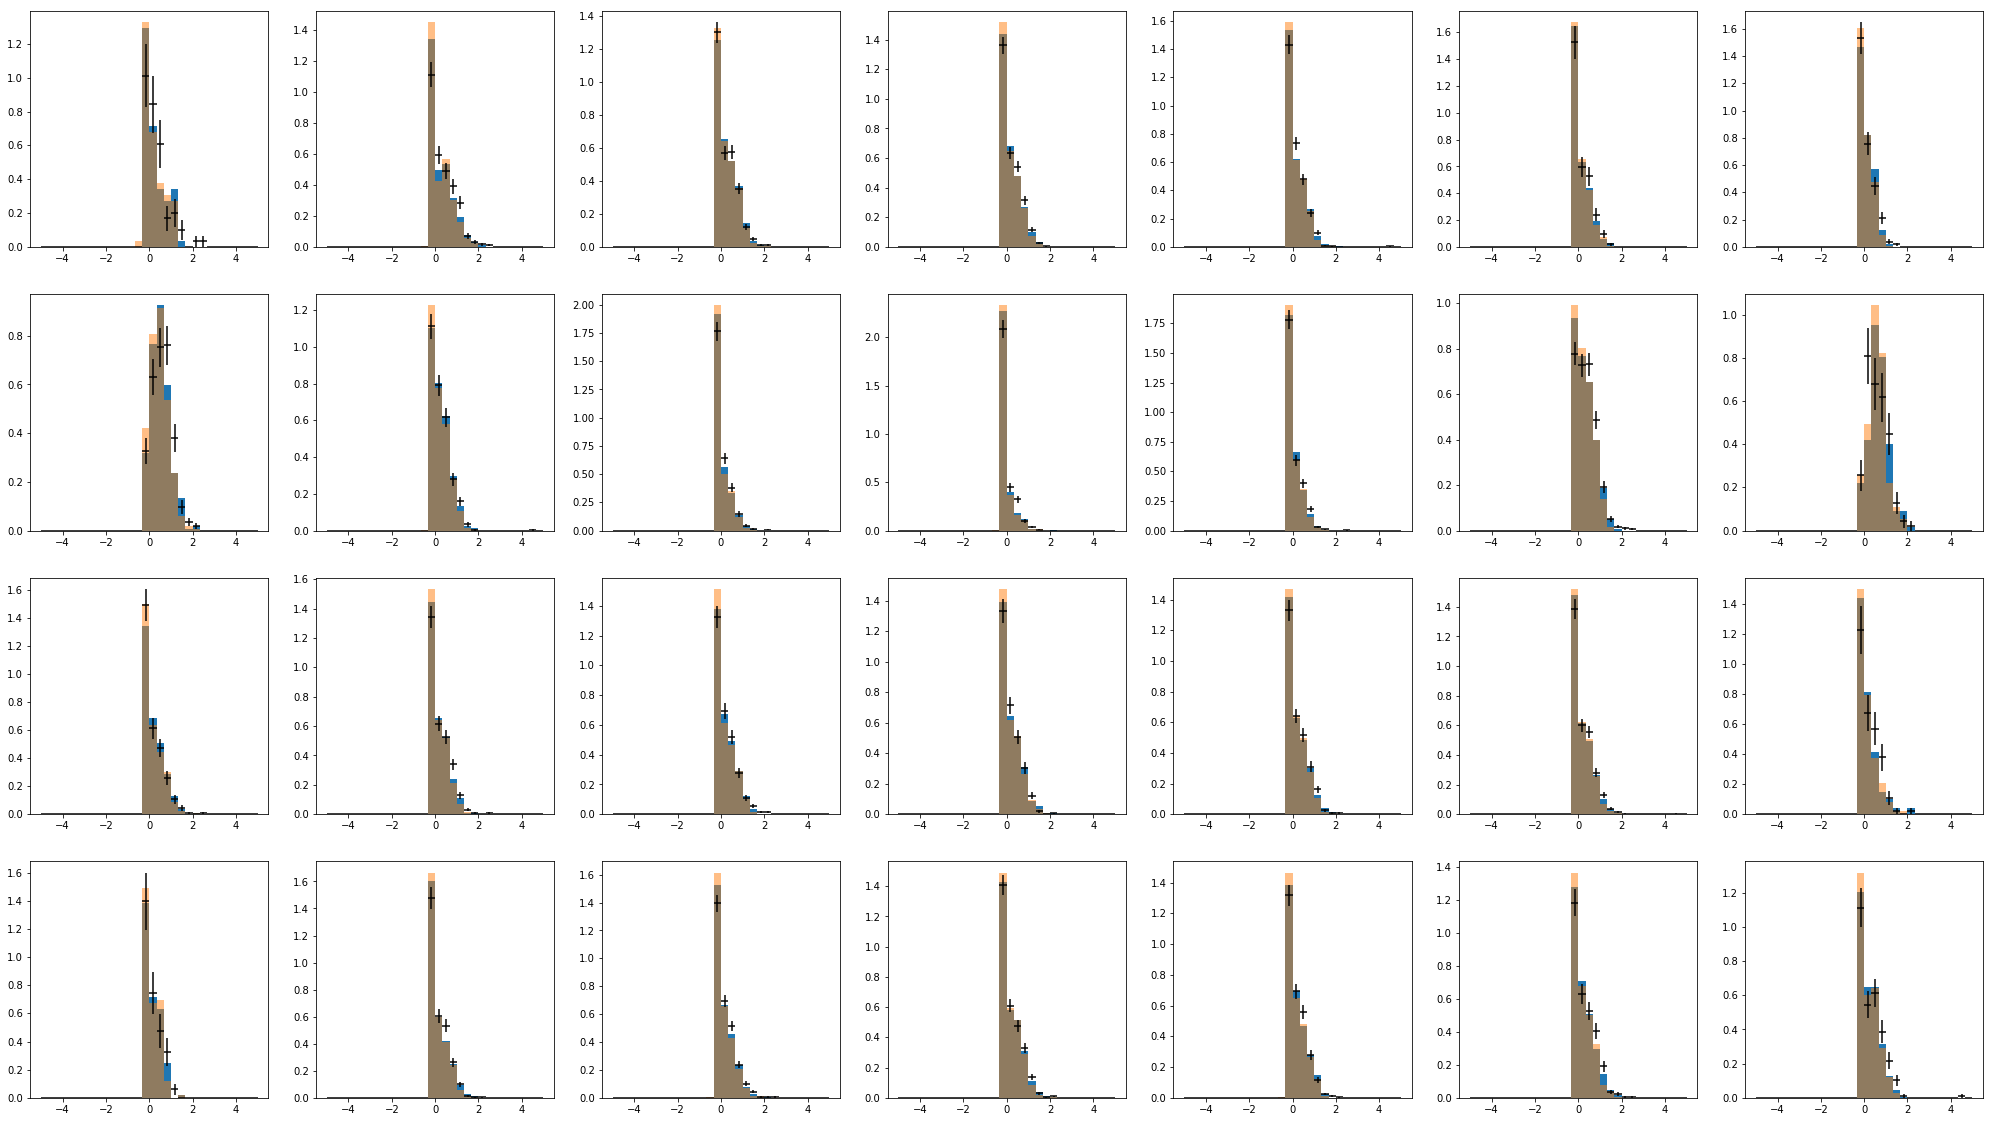

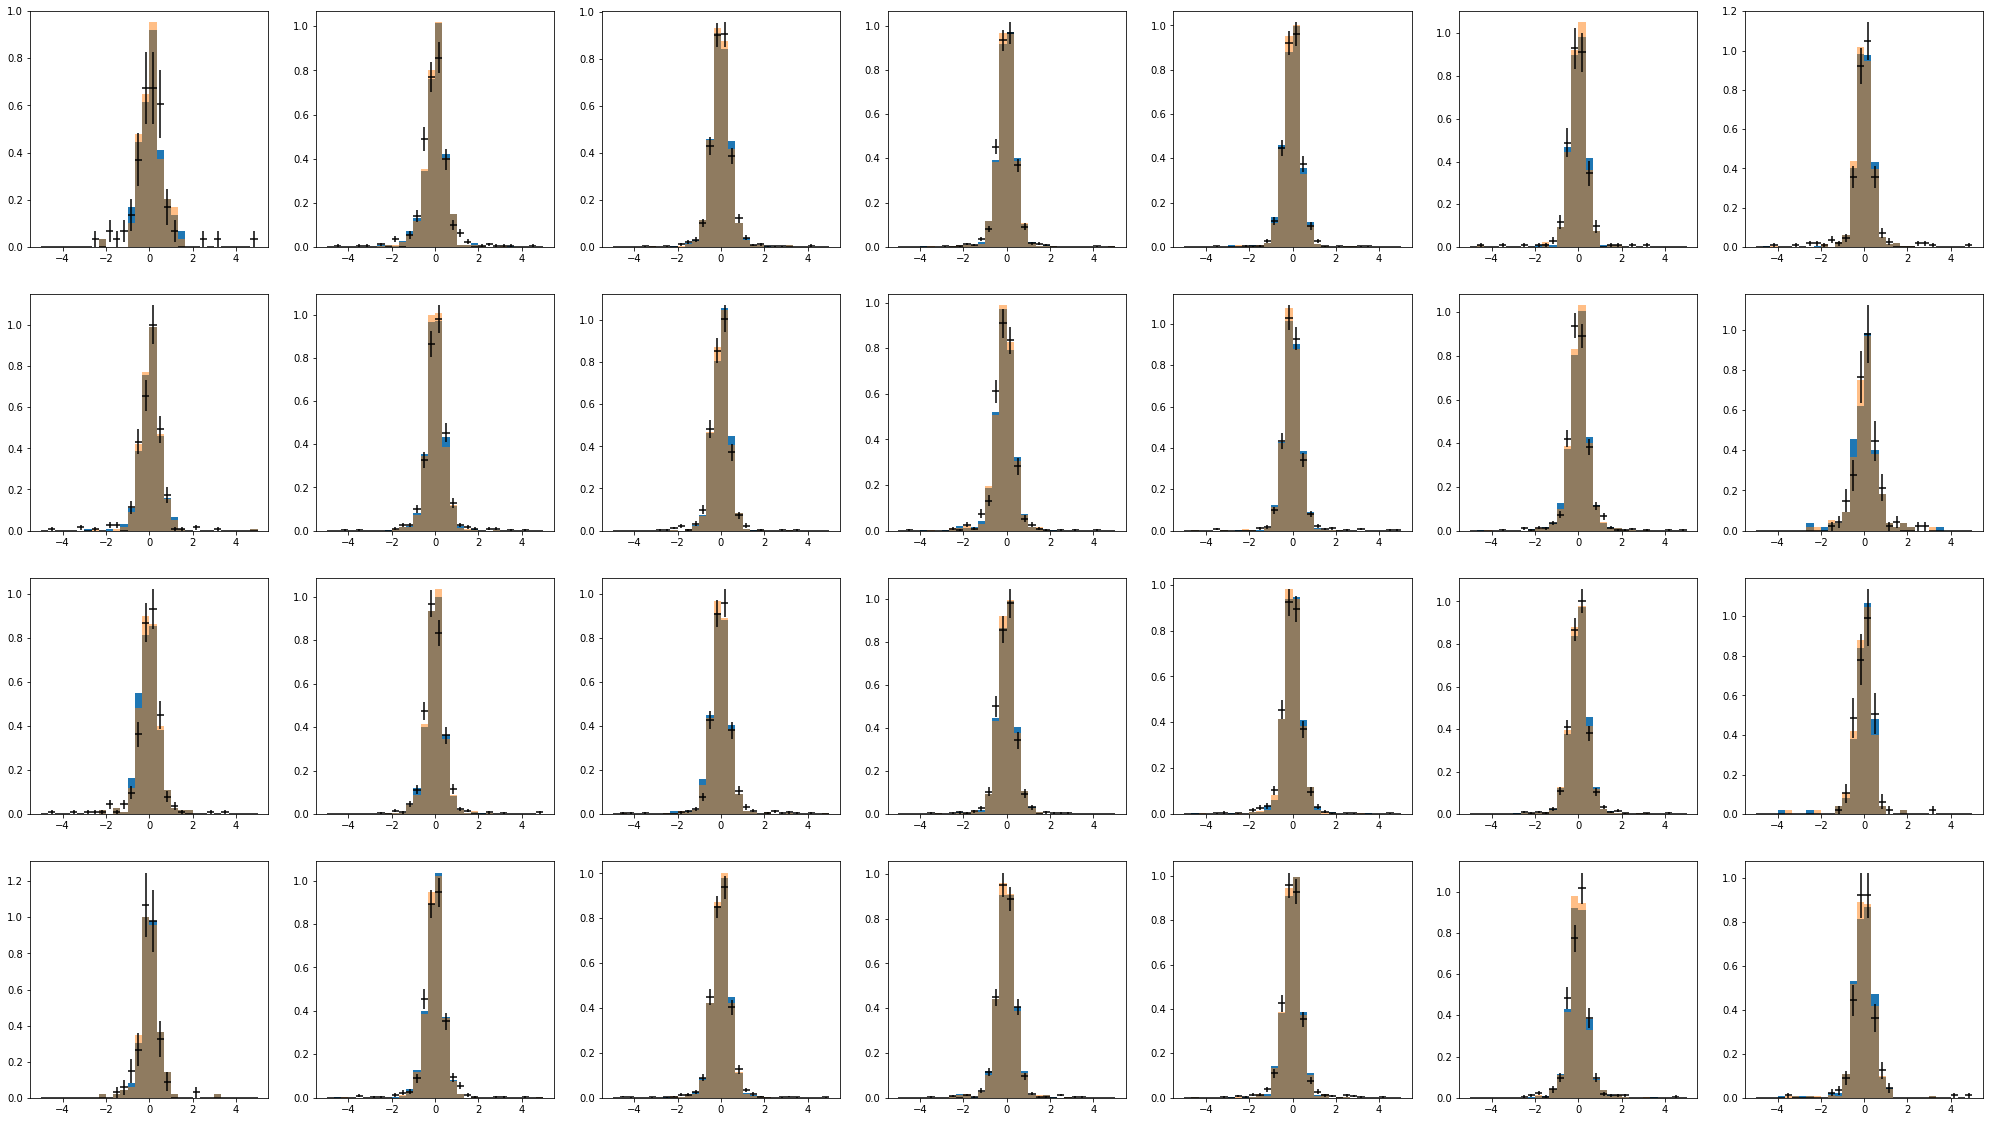

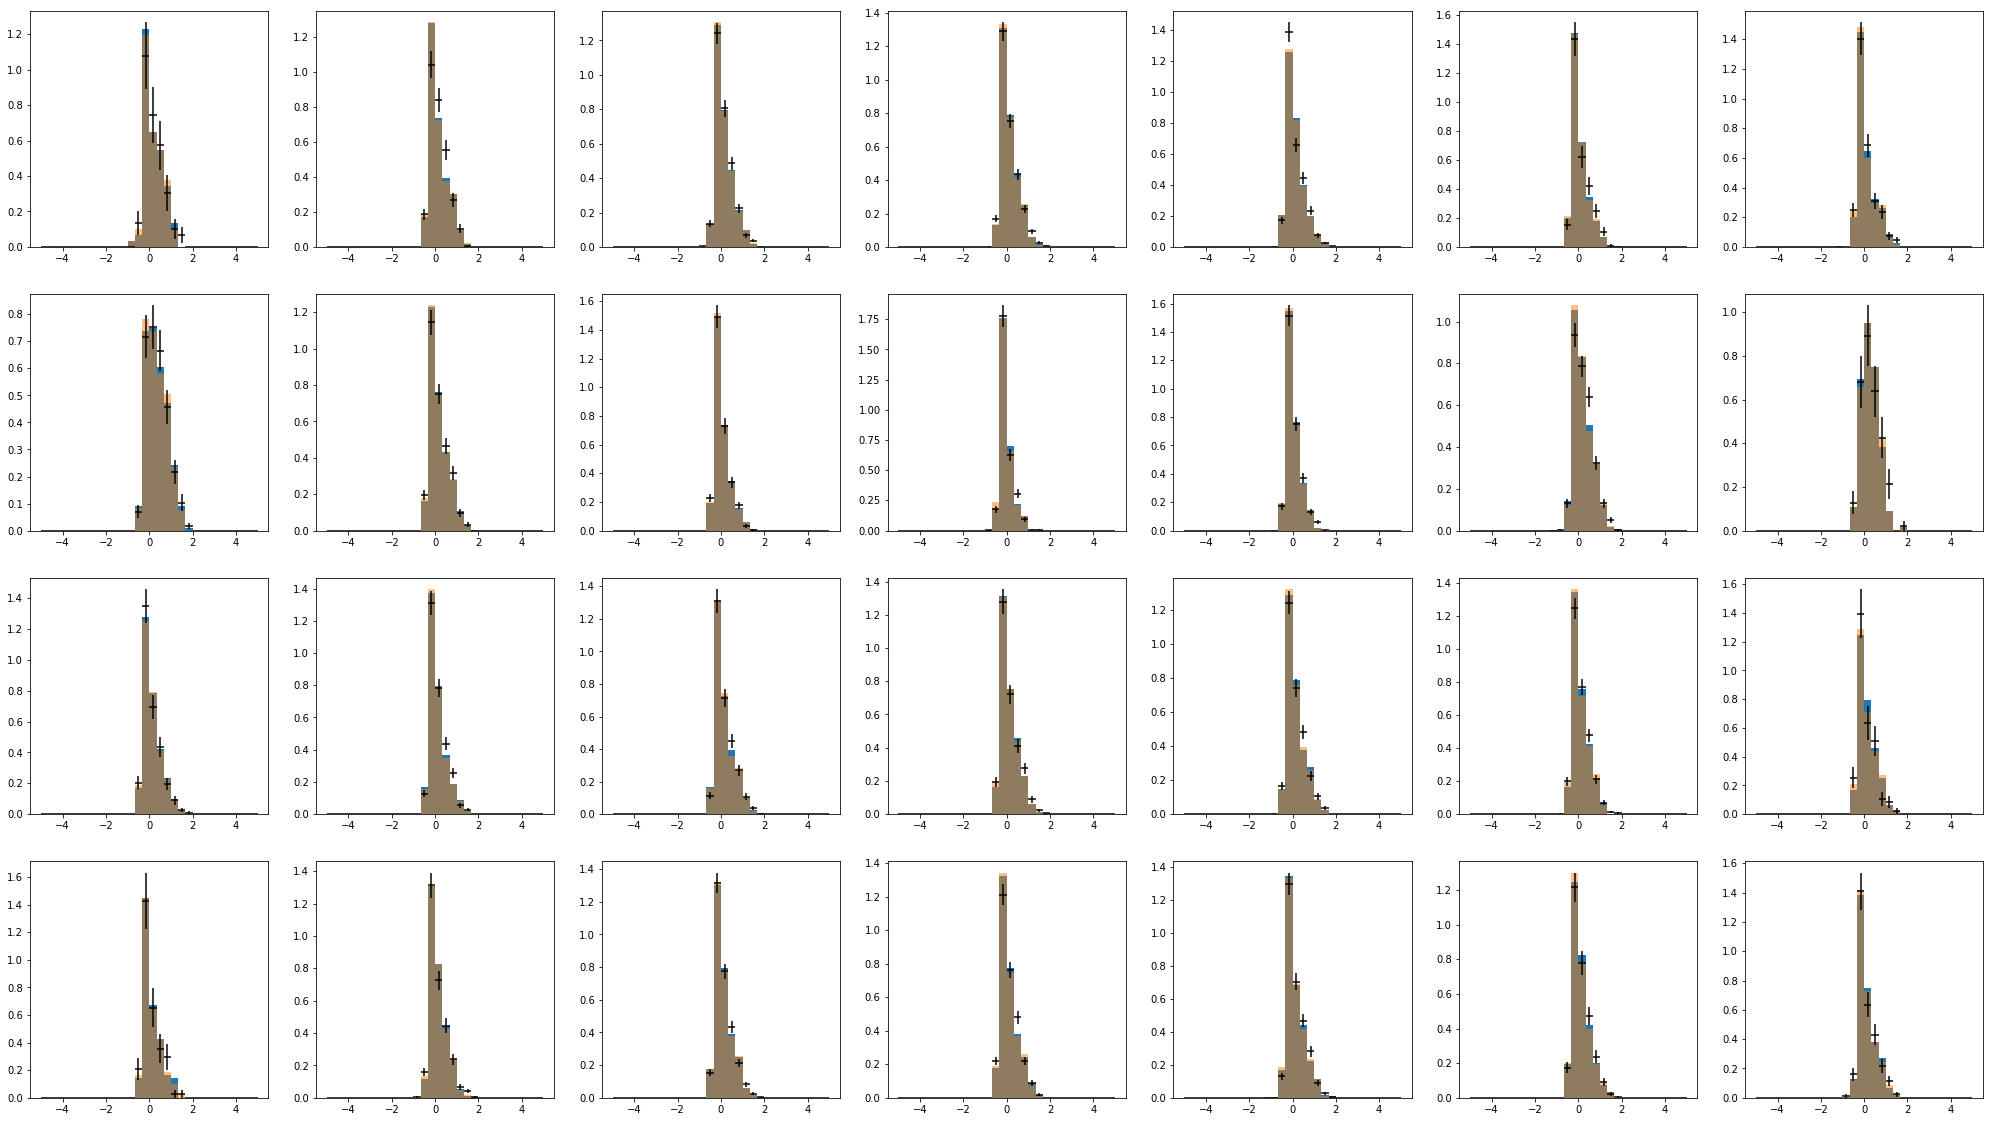

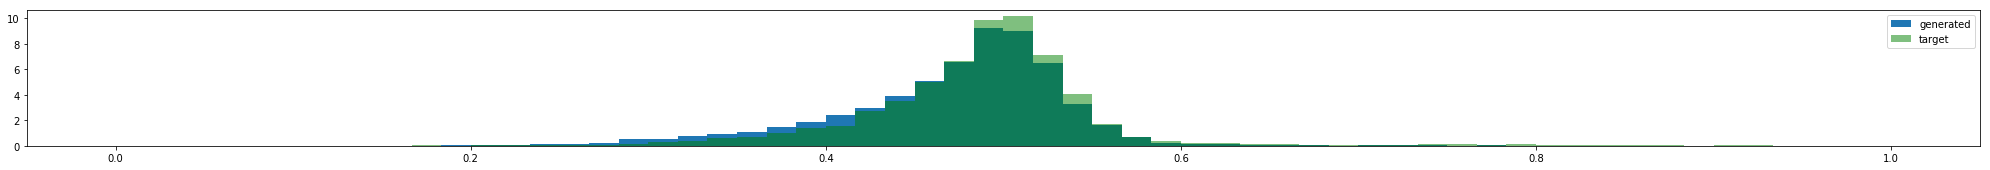

In [28]:
reload(plotting)

data_quantiles = np.percentile(data_c_test,[0,5,20,40,60,80,95,100])

# plotting.plot_summary_cond(data_x_test,data_c_test,mc_x_test,mc_c_test,mc_x_test,data_p,mc_p)
# plotting.plot_summary_cond(data_x_test,data_c_test,mc_x_morphed,mc_c_test,mc_x_test,data_p,mc_p)
plotting.plot_summary_cond(data_x_test,data_c_test,mc_x_morphed,mc_c_test,mc_x_test,data_p,mc_p,
                           do_slices=True,c_bounds=data_quantiles)
